# PROYECTO FINAL: Visión por Computador en Imágenes Médicas 3D
#### <mark> CARMEN AZORÍN MARTÍ, MARÍA CRIBILLÉS PÉREZ, LAURA LÁZARO SORALUCE, JOSÉ MANUEL ROMÁN RODRÍGUEZ

El dataset **KiTS23** (Kidney Tumor Segmentation Challenge 2023) es un conjunto de datos diseñado para fomentar investigaciones avanzadas en la segmentación de tumores renales a partir de imágenes médicas. Es parte de la serie de desafíos KiTS organizados para impulsar el desarrollo de modelos de aprendizaje automático en tareas relacionadas con el diagnóstico y tratamiento del cáncer de riñón.

Su principal obejtivo es la segmentación de tumores renales y tejido circundante en imágenes médicas, específicamente en exploraciones de tomografía computarizada (TC).

Entre los datos proporcionados tenemos:

- Imágenes de TC: Escaneos en formato volumétrico con resoluciones variadas.


- Etiquetas: Segmentaciones manuales de las estructuras de interés (riñón, tumor, etc.) realizadas por expertos médicos.

- Anotaciones adicionales: Información demográfica y datos clínicos básicos de los pacientes.

El formato del DataSet es NIfTI (.nii), que es estándar en el análisis de imágenes médicas, además los volúmenes 3D están alineados con las etiquetas correspondientes.

Este DataSet tiene una gran relevancia médica ya que apoya la investigación para automatizar el análisis de imágenes médicas, reduciendo el tiempo que los radiólogos dedican a la segmentación manual y contribuye al diagnóstico y planificación de tratamientos para el cáncer de riñón.

Entre los desafíos y tareas principales tenemos:

- Segmentación precisa de tumores renales y riñones.

- Segmentación de estructuras con formas irregulares o bordes poco definidos.

- Evaluación de modelos en términos de métricas como el Dice Similarity Coefficient (DSC) y otras métricas de segmentación médica.

- Equilibrio entre precisión y rapidez en la segmentación.

# Preprocesamiento de las imágenes 3D y 2D

##### INSTALL DATA - DO NOT EXECUTE!

Este codigo tiene como propósito configurar el entorno para trabajar con el dataset KiTS23.

Primeramente montamos google drive en el entorno de Colab para permitir la lectura y escritura de archivos directamente en la unidad de Google Drive del usuario.

A continuación creamos una carpeta para almacenar el dataset y clonamos el repositorio oficial de kiTS23 desde github.

Instalamos los paquetes y módulos necesarios que están definidos en el repositorio con `!pip install -e`, la opción `-e` indica que se realiza una instalación en modo editable, lo que permite modificar el código del repositorio local y ver los cambios inmediatamente sin reinstalar.

Por último descargamos el dataset.

In [ ]:
""" NO EJECUTAR ESTA CELDA """

from google.colab import drive

# Mount drive if not already mounted
import os
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Google Drive is already mounted")

# Create folder in MyDrive
!mkdir -p /content/drive/MyDrive/kits23_dataset
%cd /content/drive/MyDrive/kits23_dataset

# Clone repository and download data to Google Drive
!git clone https://github.com/neheller/kits23.git
%cd kits23
!pip install -e .
!kits23_download_data

Google Drive is already mounted
/content/drive/MyDrive/kits23_dataset
Cloning into 'kits23'...
remote: Enumerating objects: 15592, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (39/39), done.
^C
[Errno 2] No such file or directory: 'kits23'
/content/drive/MyDrive/kits23_dataset
Obtaining file:///content/drive/MyDrive/kits23_dataset
ERROR: file:///content/drive/MyDrive/kits23_dataset does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
/bin/bash: line 1: kits23_download_data: command not found


##### INSTALL LIBRARIES

In [27]:
""" PRIMERA CELDA A EJECUTAR """

%pip install batchgenerators
%pip install segmentation-models-pytorch
%pip install monai[all]
%pip install monai[cuda]
%pip install torchmetrics

  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 14.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [194]:
from re import I
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
#from google.colab import drive
from mpl_toolkits.mplot3d import Axes3D
import os
import gc
from scipy.ndimage import zoom
from fastai.vision.all import *
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn.functional import softmax
import torch.optim as optim
from re import U
from tqdm import tqdm
import glob
from monai.data import Dataset, CacheDataset, load_decathlon_datalist
from monai.networks.nets import UNet
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from monai.networks.nets import SegResNet

In [195]:
""" IMPORTANTE: NO EXISTEN LOS CASOS [300, 399]
- TRAINING: CASOS [0,299]+[400, 436] INCLUIDOS (337 CASOS)
- VALIDATION: CASOS [437, 506] INCLUIDOS (70 CASOS)
- TEST: CASOS [506, 587] INCLUIDOS (82 CASOS) """
# RANGOS DE CASOS
valid_cases = [i for i in range(0, 588) if not (300 <= i <= 399)]  # Índices de los casos que existen, excluir casos 300-399
train_cases_full = valid_cases[:406]
test_cases = valid_cases[406:] # Casos test
train_cases = train_cases_full[:337] # Casos train
val_cases = train_cases_full[337:] # Casos val

In [196]:
device = "cuda" if torch.cuda.is_available() else "cpu"

En esta parte definimos la función `resize_image`, la cual cambia el tamaño de las imágenes volumétricas 3D al tamaño objetivo (target_shape).

Esta función calcula factores de escala para cada dimensión de la imagen y aplica interpolación lineal (order=1) para redimensionar.

También definimos la función `load_images`, esta función carga las imágenes volumétricas desde archivos .nii.gz usando nibabel.

`get_fdata()`: Convierte el contenido del archivo en un array de datos numéricos.

Por último definimos `preprecess_and_save`, esta función sigue los siguientes pasos:

- Iteración sobre casos válidos:
  - Construye las rutas de los archivos de imagen (imaging.nii.gz) y máscaras (segmentation.nii.gz) para cada caso.

- Preprocesamiento:
  - Redimensionar: Cambia las dimensiones de las imágenes y máscaras al tamaño objetivo (128x128x128).
  - Normalización Z-Score:
    - Resta la media y divide por la desviación estándar para escalar la imagen.
  - Máscaras: Asegura que las máscaras tengan valores enteros.

- Guardar:
  - Guarda las imágenes y máscaras preprocesadas como arrays NumPy (.npy) en la carpeta preprocessed_path.



In [ ]:
# NO VOLVER A EJECUTAR
# Montamos el Google Drive
if not os.path.exists('/content/drive'):
  drive.mount('/content/drive') # Si no está ya montado
else:
  print("Google Drive is already mounted") # Si ya está montado

# Definimos el path de las imágenes del dataset
dataset_path = '/content/drive/MyDrive/kits23/dataset/'
preprocessed_path = '/content/drive/MyDrive/kits23/preprocessed/'
os.makedirs(preprocessed_path, exist_ok=True)

# Para redimensionar imágenes a una forma estándar
def resize_image(image, target_shape):
  factors = [t / s for t, s in zip(target_shape, image.shape)]
  return zoom(image, factors, order=1)  # `order=1` aplica interpolación lineal

# Cargar imágenes desde un archivo .nii
def load_images(file_path):
  nii_image = nib.load(file_path)
  image_data = nii_image.get_fdata()
  return image_data

def preprocess_and_save(dataset_path, output_path, valid_cases, target_shape=(128, 128, 128)):
  for i in valid_cases:  # Todos nuestros casos
    image_path = os.path.join(dataset_path, f"case_{i:05d}/imaging.nii.gz")
    mask_path = os.path.join(dataset_path, f"case_{i:05d}/segmentation.nii.gz")
    try:
      # Cargar imágenes y máscaras
      image = resize_image(load_images(image_path), target_shape)
      mask = resize_image(load_images(mask_path), target_shape)

      # Normalización Z-Score para la imagen
      mean_value = np.mean(image)
      std_value = np.std(image)
      image = (image - mean_value) / std_value

      # Asegurar que las máscaras sean enteros
      mask = mask.astype(np.int32)

      # Guardar como archivos NumPy
      np.save(os.path.join(output_path, f"case_{i:05d}_image.npy"), image)
      np.save(os.path.join(output_path, f"case_{i:05d}_mask.npy"), mask)
      print(f"Procesado y guardado caso {i}")
    except Exception as e:
      print(f"Error procesando el caso {i}: {e}")

preprocess_and_save(dataset_path, preprocessed_path, valid_cases)



Mounted at /content/drive
Procesado y guardado caso 0
Procesado y guardado caso 1
Procesado y guardado caso 2
Procesado y guardado caso 3
Procesado y guardado caso 4
Procesado y guardado caso 5
Procesado y guardado caso 6
Procesado y guardado caso 7
Procesado y guardado caso 8
Procesado y guardado caso 9
Procesado y guardado caso 10
Procesado y guardado caso 11
Procesado y guardado caso 12
Procesado y guardado caso 13
Procesado y guardado caso 14
Procesado y guardado caso 15
Procesado y guardado caso 16
Procesado y guardado caso 17
Procesado y guardado caso 18
Procesado y guardado caso 19
Procesado y guardado caso 20
Procesado y guardado caso 21
Procesado y guardado caso 22
Procesado y guardado caso 23
Procesado y guardado caso 24
Procesado y guardado caso 25
Procesado y guardado caso 26
Procesado y guardado caso 27
Procesado y guardado caso 28
Procesado y guardado caso 29
Procesado y guardado caso 30
Procesado y guardado caso 31
Procesado y guardado caso 32
Procesado y guardado caso 3

In [ ]:
# NO VOLVER A EJECUTAR
#Preprocesamiento 2D 
def extract_2d_slices(preprocessed_path, output_2d_path, case_range, axis=0):
    os.makedirs(output_2d_path, exist_ok=True)
    for i in case_range:
        try:
            case_id = f"case_{i:05d}"
            image_path = os.path.join(preprocessed_path, f"{case_id}_image.npy")
            mask_path = os.path.join(preprocessed_path, f"{case_id}_mask.npy")

            # Cargar los volúmenes
            image = np.load(image_path)
            mask = np.load(mask_path)

            # Extraer cortes 2D
            for idx in range(image.shape[axis]):
                if axis == 0:  # Axial
                    image_slice = image[idx, :, :]
                    mask_slice = mask[idx, :, :]
                elif axis == 1:  # Sagital
                    image_slice = image[:, idx, :]
                    mask_slice = mask[:, idx, :]
                elif axis == 2:  # Coronal
                    image_slice = image[:, :, idx]
                    mask_slice = mask[:, :, idx]
                else:
                    raise ValueError("El eje debe ser 0, 1 o 2")

                # Guardar las imágenes y máscaras
                np.save(os.path.join(output_2d_path, f"{case_id}_slice_{idx:03d}_image.npy"), image_slice)
                np.save(os.path.join(output_2d_path, f"{case_id}_slice_{idx:03d}_mask.npy"), mask_slice)
                print(f"Guardado: {case_id}_slice_{idx:03d}")
        except Exception as e:
            print(f"Error procesando el caso {i}: {e}")

# Definir los parámetros y ejecutar
output_2d_path = '/content/drive/MyDrive/kits23/slices_2d/' 
valid_cases = [i for i in range(0, 589) if not (300 <= i <= 399)]  # Índices de los casos que existen, excluir casos 300-399
extract_2d_slices(preprocessed_path, output_2d_path, valid_cases, axis=0) #es el axial el que sale en la pagina de kits23, pero se puede elegir a voluntad


Se han truncado las últimas 5000 líneas del flujo de salida.
Guardado: case_00548_slice_121
Guardado: case_00548_slice_122
Guardado: case_00548_slice_123
Guardado: case_00548_slice_124
Guardado: case_00548_slice_125
Guardado: case_00548_slice_126
Guardado: case_00548_slice_127
Guardado: case_00549_slice_000
Guardado: case_00549_slice_001
Guardado: case_00549_slice_002
Guardado: case_00549_slice_003
Guardado: case_00549_slice_004
Guardado: case_00549_slice_005
Guardado: case_00549_slice_006
Guardado: case_00549_slice_007
Guardado: case_00549_slice_008
Guardado: case_00549_slice_009
Guardado: case_00549_slice_010
Guardado: case_00549_slice_011
Guardado: case_00549_slice_012
Guardado: case_00549_slice_013
Guardado: case_00549_slice_014
Guardado: case_00549_slice_015
Guardado: case_00549_slice_016
Guardado: case_00549_slice_017
Guardado: case_00549_slice_018
Guardado: case_00549_slice_019
Guardado: case_00549_slice_020
Guardado: case_00549_slice_021
Guardado: case_00549_slice_022
Guardado:

In [ ]:
drive.flush_and_unmount()  # Desmonta Google Drive de manera segura
drive.mount('/content/drive')  # Monta Google Drive nuevamente

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/kits23/slices_2d/'
if os.path.exists(path):
    print(f"El directorio {path} existe.")
else:
    print(f"El directorio {path} no existe. Creándolo...")
    os.makedirs(path, exist_ok=True)

El directorio /content/drive/MyDrive/kits23/slices_2d/ existe.


In [ ]:
# Definimos el path de las imágenes del dataset
preprocessed_path = '/content/drive/MyDrive/preprocessed/'
output_2d_path = '/content/drive/MyDrive/kits23/slices_2d/'

# mostrar cantidad de elementos en la carpeta
count = sum([len(files) for _, _, files in os.walk(preprocessed_path)])
print(f"Archivos en preprocessed_path: {count}")


count = sum([len(files) for _, _, files in os.walk(output_2d_path)])
print(f"Archivos en output_2d_path: {count}")

Archivos en preprocessed_path: 976
Archivos en output_2d_path: 124928


In [197]:
#Importar ruta del servidor 
import os

# Definimos el path de las imágenes del dataset
preprocessed_path = '/mnt/homeGPU/mcribilles/proy_final/preprocessed'
output_2d_path = '/mnt/homeGPU/mcribilles/proy_final/2d_slices'


# mostrar cantidad de elementos en la carpeta
count = sum([len(files) for _, _, files in os.walk(preprocessed_path)])
print(f"Archivos en preprocessed_path: {count}")


count = sum([len(files) for _, _, files in os.walk(output_2d_path)])
print(f"Archivos en output_2d_path: {count}")

Archivos en preprocessed_path: 976
Archivos en output_2d_path: 124928


### Explicación preprocesamiento

#### Intensidades de Hounsfield
La escala de Unidades Hounsfield es el resultado de la transformación de la escala de coeficientes de atenuación lineal de rayos X en una nueva escala en la cual el valor de atenuación del agua destilada en Condiciones Normales de Presión y Temperatura (CNPT) se define como 0 unidades de Hounsfield (HU), mientras que la radiodensidad del aire en Condiciones Normales de Presión y Temperatura (CNPT) se define como -1000 HU, extendiéndose más allá de las 1000 HU asignadas al nivel de absorción del hueso compacto.
Algunos valores interesantes para los tejidos y sustancias del cuerpo humano son:
* Aire −1000 HU
* Pulmón −500 HU
* Grasa	−100 a −55 HU
* Agua 0 HU
* Líquido cerebroespinal	15 HU
* Riñón	30 HU
* Sangre 30 a 45 HU
* Músculo	10 a 40 HU
* Sustancia Gris 37 a 45 HU
* Sustancia Blanca 20 a 30 HU
* Hígado 40 a 60 HU
* Medios de contraste	100 a 300 HU

¿Cómo normalizar las imágenes médicas con intensidad de Hounsfield?
La normalización de la intensidad es esencial. Ayuda a nuestra red a converger más eficientemente. Las fluctuaciones en los valores de los vóxeles se reducen, lo que conduce a un colector más suave de la función de pérdida, y por lo tanto los beneficios de formación. Además, tener la entrada en un rango alrededor de 0 permite al modelo actualizar los pesos de forma más consistente porque el tamaño del paso fluctúa menos. Esto reduce el problema de la explosión de gradientes.

Lo más normal es que se utilice la normalización min-max porque es muy intuitiva, cosa que no pasa en las imágenes médicas ya que:
1. La intensidad de la imagen refleja el tipo de tejido
2. La intensidad de la imagen es relativa
3. El rango de intensidad no está acotado


Vemos como el rango supera lo que estamos aconstumbrados a manejar que suele ser entre 0 y 255 o bien entre 0 y 1. Esto se debe a que las imágenes médicas se miden en intesidades Hounsfield (CT scans).En cuanto a la máscara, hay segementación con tres clases (fondo 0, primera región de interés 1 y segunda región de interés 2).

# Dataset 3d

In [106]:
# # Check if Google Drive is already mounted
# if not os.path.exists('/content/drive'):
#   drive.mount('/content/drive')  # Mount only if it's not already mounted
# else:
#   print("Google Drive is already mounted")
# preprocessed1_path = '/content/drive/MyDrive/preprocessed1/'

if os.path.exists(preprocessed_path):
    print(f"El directorio {preprocessed_path} existe.")
else:
    print(f"El directorio {preprocessed_path} no existe. Creándolo...")

#os.makedirs(preprocessed_path, exist_ok=True)

count = sum([len(files) for _, _, files in os.walk(preprocessed_path)])
print(f"Archivos en preprocessed_path: {count}")


El directorio /mnt/homeGPU/mcribilles/proy_final/preprocessed existe.
Archivos en preprocessed_path: 976


**IMPORTANTE EJECUTAR SI DA ERROR AL EJECUTAR LA RED**

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Mounted at /content/drive


En este código cargamos una imagen del dataset y la visualizamos en 3D.

Para empezar filtramos los archivos que tienen extensión .npy o .nii.gz (que son los formatos de imagen esperados). Los archivos filtrados se almacenan en la lista `image_files`.

Después verficamos que hay archivos y cargamos el primero.

A continuación cargamos el archivo según su formato:

- Si el archivo tiene extensión .npy, se carga como una matriz de NumPy usando np.load.

- Si el archivo tiene extensión .nii o .nii.gz, se carga utilizando la librería nibabel para manejar el formato NIfTI. Se obtiene la data del archivo usando get_fdata().

Verificamos las dimensiones y el rango de valores, estos datos se imprimen por pantalla.

Justo después normalizamos los datos para que estén entre el rango 0 y 1. Esto se logra restando el valor mínimo de la imagen y dividiendo entre el rango total de valores (`max - min`).

Creamos una máscara binaria para los voxels, esta máscara selecciona los voxels que tienen un valor mayor que un umbral (threshold). Los voxels que superen este umbral serán considerados como "presentes" y visibles en la visualización.

Creamos una matriz de colores con la misma forma que la máscara mask, pero con 4 canales (RGBA).

Los tres primeros canales (rojo, verde y azul) se llenan con los valores normalizados de la imagen.

El cuarto canal (alfa o transparencia) se ajusta según la máscara: se asigna un valor de 0.5 (semi-transparente) a los voxels que están presentes.

Por último creamos la figura y los ejes 3D, y visualizamos los voxels visibles seleccionados por la máscara.

Dimensiones del volumen: (128, 128, 128)
Rango de valores: min=0, max=3


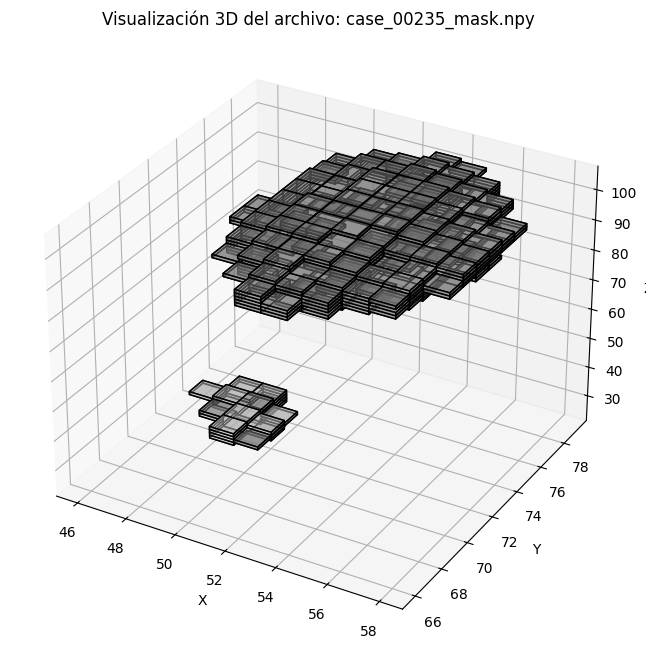

In [198]:
# Path de las imágenes
preprocessed1_path = '/mnt/homeGPU/mcribilles/proy_final/preprocessed'

# Obtener los archivos de la carpeta
image_files = [
    f for f in os.listdir(preprocessed1_path) if f.endswith(('.npy', '.nii.gz'))
]

# Visualizar el primer archivo en 3D
if image_files:
    # Seleccionamos el primer archivo
    img_path = os.path.join(preprocessed1_path, image_files[0])

    # Cargar el archivo según su formato
    if img_path.endswith('.npy'):
        img_data = np.load(img_path)  # Cargar archivo .npy
    elif img_path.endswith(('.nii', '.nii.gz')):
        nifti_img = nib.load(img_path)
        img_data = nifti_img.get_fdata()

    # Verificar dimensiones y rango de valores
    print(f"Dimensiones del volumen: {img_data.shape}")
    print(f"Rango de valores: min={np.min(img_data)}, max={np.max(img_data)}")

    # Normalizar los datos a un rango de 0 a 1
    img_data_normalized = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

    # Crear máscara binaria para voxels (filtrar valores bajos para no sobrecargar la visualización)
    threshold = 0.525  # Ajusta este valor según el volumen
    mask = img_data_normalized > threshold

    # Crear los colores para los voxels en escala de grises
    voxel_colors = np.zeros(mask.shape + (4,))  # Agregar 4 canales para RGBA
    voxel_colors[..., 0] = img_data_normalized  # Canal R
    voxel_colors[..., 1] = img_data_normalized  # Canal G
    voxel_colors[..., 2] = img_data_normalized  # Canal B
    voxel_colors[..., 3] = mask * 0.5  # Transparencia (0.5 para los voxels visibles)

    # Crear figura y ejes 3D
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Establecer vista en el gráfico
    #ax.view_init(elev=30, azim=45)

    # Visualizar voxels
    ax.voxels(mask, facecolors=voxel_colors, edgecolor='k')

    # Etiquetas de los ejes
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"Visualización 3D del archivo: {image_files[0]}")

    # Mostrar gráfico
    plt.show()
else:
    print("No se encontraron imágenes en la carpeta.")

Este código define una clase `PreprocessedDataset` que hereda de `torch.utils.data.Dataset`, lo que la convierte en un objeto adecuado para ser utilizado con PyTorch DataLoader. La clase se utiliza para cargar datos preprocesados (imágenes y máscaras) para un modelo de aprendizaje profundo en este caso U-Net.

Vamos a ver que hace cada método de la clase:

1. **init**:

  - `preprocessed_path`: Es la ruta donde se almacenan los datos preprocesados (imágenes y máscaras).
  - `case_range`: Una lista con los índices de los casos que se van a cargar. Por ejemplo, si case_range es [0, 1, 2], se cargarán los casos con identificadores "case_00000", "case_00001", y "case_00002".
  - `self.cases`: La lista de casos se genera con la sintaxis de formato de cadenas, asegurándose de que el número de cada caso tenga 5 dígitos (por ejemplo, case_00000, case_00001, etc.).

2. **len**:

  - Este método devuelve la longitud del dataset, es decir, el número de casos disponibles. Este valor se utilizará para iterar sobre el dataset durante el entrenamiento.

3. **getitem**:

  - `getitem__(self, idx)`: Este es el método clave que se llama cuando se hace una consulta en el dataset, por ejemplo, dataset[idx].
    - `case_id`: Se obtiene el identificador del caso actual utilizando el índice idx.
    - `image_path` y `mask_path`: Se construyen las rutas a los archivos de la imagen y la máscara utilizando el `case_id` y los sufijos `_image.npy` y `_mask.npy`.
    - `image` y `mask`: Se cargan las imágenes y máscaras desde los archivos .npy usando `np.load()`.
    - Normalización: Se normaliza la imagen para que sus valores estén en el rango [0, 1] usando la fórmula `(image - min) / (max - min)`.
    - Conversión a Tensor: Las imágenes y máscaras se convierten en tensores de PyTorch. Se agrega una dimensión adicional para el canal (usando `.unsqueeze(0)`), ya que PyTorch espera que los tensores de imagen tengan la forma `[batch_size, channels, height, width, depth]` para imágenes 3D.

In [199]:
class PreprocessedDataset(Dataset):
    def __init__(self, preprocessed_path, case_range):
        self.preprocessed_path = preprocessed_path
        self.cases = [f"case_{i:05d}" for i in case_range]

    def __len__(self):
        """
        Devuelve el número de casos en el dataset.
        """
        return len(self.cases)

    def __getitem__(self, idx):
        case_id = self.cases[idx]

        # Construir las rutas de los archivos
        image_path = os.path.join(self.preprocessed_path, f"{case_id}_image.npy")
        mask_path = os.path.join(self.preprocessed_path, f"{case_id}_mask.npy")

        # Cargar imagen y máscara
        image = np.load(image_path)
        mask = np.load(mask_path)

        # Normalizar imagen (0 a 1)
        image = (image - np.min(image)) / (np.max(image) - np.min(image))

        # Convertir a tensores PyTorch
        image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Añadir dimensión de canal
        mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)   # Añadir dimensión de canal

        return image_tensor, mask_tensor

Aquí creamos el DataSet y el DataLoaders para la carga de datos durante el entrenamiento, validación y prueba de un modelo.

**Creación del Datasets:**

`PreprocessedDataset`: Es la clase definida previamente para cargar los datos preprocesados (imágenes y máscaras). En estos tres casos:

  - `train_dataset`: Se crea un dataset para los datos de entrenamiento utilizando el rango de casos definidos en `train_cases`.
  - `val_dataset`: Se crea un dataset para los datos de validación utilizando el rango de casos definidos en `val_cases`.
  - `test_dataset`: Se crea un dataset para los datos de prueba utilizando el rango de casos definidos en `test_cases`.

Para cada uno de estos datasets, el parámetro `preprocessed1_path` se pasa como la ruta donde están almacenados los archivos .npy con las imágenes y máscaras.

**Creación del DataLoaders:**

`DataLoader`: La clase `DataLoader` de PyTorch permite cargar los datos en lotes de manera eficiente. Toma el `Dataset` y genera un iterador para recorrer los datos.
  - `train_loader`: Se utiliza para cargar los datos de entrenamiento. Los parámetros importantes son:

    - `batch_size=batch_size`: El tamaño de cada lote es de 8.
    - `shuffle=True`: Esto asegura que los datos se barajen (mezclen) en cada época de entrenamiento para evitar que el modelo se sesgue.
  - `val_loader`: Se utiliza para cargar los datos de validación. Tiene un `batch_size` igual a 8, pero con `shuffle=False`, ya que no es necesario barajar los datos de validación.

  - `test_loader`: Se utiliza para cargar los datos de prueba, con `shuffle=False` también, ya que no se necesita barajar los datos en el conjunto de prueba.

In [200]:
# Crear Datasets
train_dataset = PreprocessedDataset(preprocessed1_path, train_cases)
val_dataset = PreprocessedDataset(preprocessed1_path, val_cases)
test_dataset = PreprocessedDataset(preprocessed1_path, test_cases)



In [201]:
# Definit train pairs como pares imagen, mascara del train_dataset
train_pairs = [(train_dataset[i][0], train_dataset[i][1]) for i in range(len(train_dataset))]

In [202]:
class_counts = [701371044, 4110016, 1202869, 56295]

# Calcular pesos para realizar sobremuestreo
class_weights = [0,0,0,0]
for i in range(len(class_counts)):
    class_weights[i] = 1.0 / class_counts[i]

sample_weights = []
for _, mask in tqdm(train_pairs):
    # mask = load_mask(mask_path).numpy()
    unique, counts = np.unique(mask, return_counts=True)
    weight = sum(class_weights[int(cls)] * count for cls, count in zip(unique, counts))
    sample_weights.append(weight.item())

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

100%|██████████| 337/337 [00:12<00:00, 26.52it/s]


In [203]:
# Crear DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Para verificar que el Dataset funciona procedemos a mostrar una imagen y una máscara.

`plt.imshow(example_image[0, :, :, 50], cmap="gray")`: Muestra un slice de la imagen en el eje Z=50 (específicamente, la imagen a lo largo de la dimensión de profundidad). El índice 0 selecciona el canal de la imagen (ya que tiene un solo canal).


Image shape: torch.Size([1, 128, 128, 128]), Mask shape: torch.Size([1, 128, 128, 128])


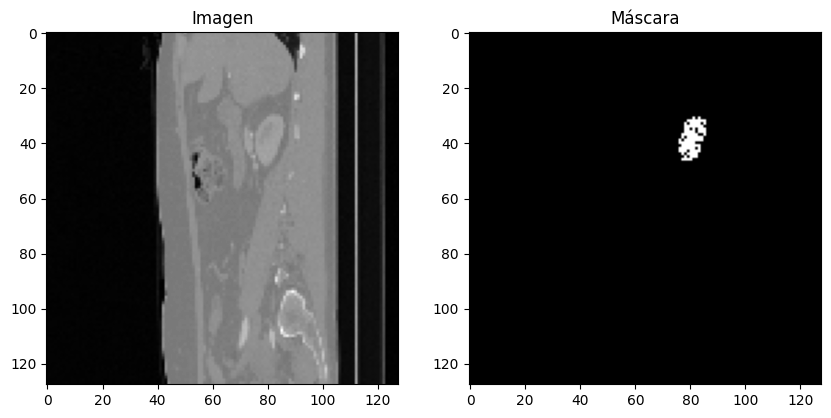

In [204]:
# Verificar un ejemplo del dataset
example_image, example_mask = train_dataset[0]
print(f"Image shape: {example_image.shape}, Mask shape: {example_mask.shape}")

# Visualizar
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(example_image[0, :, :, 50], cmap="gray")  # Mostrar un slice de la imagen
plt.title("Imagen")

plt.subplot(1, 2, 2)
plt.imshow(example_mask[0, :, :, 50], cmap="gray")  # Mostrar el mismo slice de la máscara
plt.title("Máscara")
plt.show()

Función para evaluar el modelo

In [205]:
def evaluate_model(model, data_loader, num_classes=4):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    all_metrics = {"IoU": [], "Dice": []}

    with torch.no_grad():
        for images, masks in data_loader:
            images, masks = images.to(device), masks.to(device)

            # Predicciones
            outputs = model(images)

            metrics = compute_metrics(outputs, masks.squeeze(1).long(), num_classes=num_classes)

            all_metrics["IoU"].append(metrics["IoU"])
            all_metrics["Dice"].append(metrics["Dice"])

    # Promediar métricas
    avg_iou = np.mean(all_metrics["IoU"], axis=0)
    avg_dice = np.mean(all_metrics["Dice"], axis=0)

    print(f"Average IoU: {avg_iou}")
    print(f"Average Dice: {avg_dice}")

    return {"IoU": avg_iou, "Dice": avg_dice}

## Modelo U-Net 3D

Ahora definimos U-Net 3D:

- `spatial_dims=3`: Indica que se trabaja con datos 3D (en lugar de 2D).
- `in_channels=1`: La entrada del modelo tiene 1 canal (por ejemplo, una imagen en escala de grises o una sola secuencia de volumen).
- `out_channels=4`: El modelo tiene 4 salidas una por cada tipo de máscara.
- `channels=(32, 64, 128, 256, 512)`: Especifica las dimensiones de los filtros en cada capa del encoder y decoder del U-Net. Estas son las características de las capas convolucionales en cada etapa de la red.
- `strides=(2, 2, 2, 2)`: Define los pasos de convolución o "strides" para cada capa. Aquí se usa un stride de 2 para las capas convolucionales, lo que reduce la resolución espacial.
- `num_res_units=3`: Especifica que se usarán 3 bloques residuales en el encoder (esto ayuda a entrenar redes más profundas sin perder información).


El modelo se mueve automáticamente a la GPU si está disponible, de lo contrario, se usa la CPU.

**Inicialización de los pesos:**

Este bloque de código inicializa los pesos del modelo:

- `Conv3d`: Si la capa es una convolución 3D, se usa inicialización de He (usando la función kaiming_normal_), que es adecuada para capas con activaciones ReLU. La inicialización de He ayuda a mitigar problemas de desvanecimiento o explosión del gradiente durante el entrenamiento.
- `BatchNorm3d`: Si la capa es una capa de normalización por lotes (batch normalization), los pesos se inicializan a 1 y los sesgos a 0.

**Funciones de pérdida y optimizador:**

- `dice_loss`: Evalúa la simulitud entre las predicciones y las etiquetas verdaderas para cada clase, es ideal para segmentación, ya que mide que tan bien se superponen las regiones predichas con las verdaderas.
- `combined_loss`: Combina `dice_loss` y `CrossEntropyLoss`, balanceando los beneficios de ambas, el peso de cada pérdida es 0.5.
- `focal_loss`: Modifica `CrossEntropy` para dar más peso a ejemplos difíciles, es útil cuando el dataset está desbalanceado.
  - `alpha=0.25`: Controla el peso entre clases.
  - `gamma=2`: Determina cúanto énfasis se da a los ejemplos dificiles.

- `optimizer`: Se utiliza el optimizador AdamW para actualizar los pesos del modelo.

**Scheduler del Learning Rate:**

Este bloque configura un scheduler para el optimizador, que ajusta el learning rate (tasa de aprendizaje) durante el entrenamiento:

- `ReduceLROnPlateau`: Esta estrategia reduce la tasa de aprendizaje cuando la métrica de validación (en este caso, la pérdida) deja de mejorar.
- `mode='min'`: Indica que el learning rate se reducirá cuando la pérdida de validación alcance un mínimo.
- `patience=5`: La cantidad de épocas que el modelo esperará sin mejora en la pérdida de validación antes de reducir la tasa de aprendizaje.
- `factor=0.5`: Cuando la pérdida no mejora, el learning rate se reducirá a la mitad.

In [206]:
from monai.networks.nets import UNet
import torch.nn as nn
from torch.nn.functional import softmax

# Definir U-Net 3D
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=4,
    channels=(32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2),
    num_res_units=3,
).to("cuda" if torch.cuda.is_available() else "cpu")

# Inicialización de pesos
def initialize_weights(m):
    if isinstance(m, nn.Conv3d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm3d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

# Definir funciones de pérdida (Dice + CrossEntropy)
def dice_loss(predictions, targets, num_classes=4):
    smooth = 1e-6
    dice = 0
    for cls in range(num_classes):
        pred = (torch.argmax(predictions, dim=1) == cls).float()
        target = (targets == cls).float()
        intersection = (pred * target).sum()
        dice += (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice / num_classes

def combined_loss(predictions, targets):
    ce_loss = nn.CrossEntropyLoss()(predictions, targets.long())
    d_loss = dice_loss(predictions, targets)
    return 0.5 * ce_loss + 0.5 * d_loss

def focal_loss(logits, targets, alpha=0.25, gamma=2):
    probas = softmax(logits, dim=1)  # Convertir logits a probabilidades
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).permute(0, 4, 1, 2, 3).float()

    # Calcular el término focal y la pérdida
    focal_term = (1 - probas) ** gamma
    loss = -alpha * focal_term * targets_one_hot * torch.log(probas + 1e-6)

    return loss.mean()

# Definir función de pérdida y optimizador
#loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Scheduler para ajustar el learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)


Aquí definimos una función que calcula dos métricas comúnmente usadas en tareas de segmentación de imágenes: IoU (Intersection over Union) y Dice. Estas métricas se calculan para cada clase en un problema de segmentación de imágenes multiclase.


Funcionamiento del código:

1. Conversión de logits a clases predichas:
Se toma la salida de las predicciones del modelo (predictions), y se calcula la clase predicha para cada píxel con `torch.argmax(predictions, dim=1)`. Esto selecciona la clase con el valor más alto en la dimensión correspondiente a las clases.

2. Inicialización de las listas para IoU y Dice:
Se crean dos listas vacías, iou y dice, para almacenar los resultados de las métricas por clase.

3. Cálculo de IoU y Dice por clase: Para cada clase (de 0 a num_classes-1):

  - Máscara predicha: Se crea una máscara binaria donde los píxeles que pertenecen a la clase actual (cls) en pred_classes se marcan como 1, y los demás como 0.
  - Máscara objetivo: De manera similar, se crea una máscara binaria para los píxeles que pertenecen a la clase actual en targets.
Se calculan dos métricas:

    - IoU (Intersection over Union): Es la intersección entre la máscara predicha y la máscara objetivo, dividida por la unión de ambas. Esto mide qué tan bien se superponen las predicciones con las máscaras reales.

    - Dice: Es una métrica similar a IoU, pero usa el doble de la intersección en el numerador.

In [207]:
def compute_metrics(predictions, targets, num_classes=4):
    # Convertir logits a clases
    pred_classes = torch.argmax(predictions, dim=1)

    iou = []
    dice = []

    for cls in range(num_classes):
        pred_mask = (pred_classes == cls).float()
        target_mask = (targets == cls).float()

        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        iou_cls = intersection / (union - intersection + 1e-6)
        dice_cls = (2 * intersection) / (union + 1e-6)

        iou.append(iou_cls.item())
        dice.append(dice_cls.item())

    return {"IoU": iou, "Dice": dice}

Este código define una función para entrenar un modelo de segmentación (en este caso, un modelo U-Net 3D) y luego la ejecuta.

**Función de entrenamiento:**

Parámetros:

- model: El modelo que será entrenado (en este caso, el modelo U-Net).
- train_loader: El cargador de datos para el conjunto de entrenamiento. Proporciona los lotes (batches) de imágenes y sus máscaras correspondientes.
- val_loader: El cargador de datos para el conjunto de validación. Se usa para evaluar el modelo después de cada época.
- epochs: Número de épocas (iteraciones completas sobre todo el conjunto de entrenamiento) durante el entrenamiento.

Dentro de la función comprobamos si hay GPU para cambiar, si no con CPU.

Se comienza el ciclo de entrenamiento, donde `epochs` es el número de veces que se pasará por todo el conjunto de datos. `model.train()` establece el modelo en modo de entrenamiento (esto afecta a ciertos comportamientos como el Dropout, si se usa).

Luego, se inicializa la variable `train_loss` para acumular la pérdida durante el entrenamiento.

A continuación, cargamos los lotes de imágenes y máscaras.

Movemos todo a la GPU (si está disponible).

Realizamos el forward pass (se calculan las salidas del modelo).

Calculamos la pérdida entre las salidas del modelo y las máscaras reales usando la función de pérdida `loss_function`.

Realizmos el backward pass para calcular los gradientes.

Luego, el optimizador realiza un paso de actualización para ajustar los pesos del modelo.

Finalmente, se acumula el valor de la pérdida en train_loss.

Después del ciclo de entrenamiento, el modelo se evalúa en el conjunto de validación.

`model.eval()` cambia el modelo al modo de evaluación, lo que desactiva comportamientos como Dropout.

Dentro del ciclo de validación, se calculan las salidas del modelo y se acumula la pérdida de validación (val_loss) sin calcular gradientes (porque no se realiza un backward pass aquí).

Ajustamos el learning rate e imprimimos la pérdida promedio en el conjunto de entrenamiento (train_loss) y en el conjunto de validación (val_loss).

In [138]:
def train_model(model, train_loader, val_loader, epochs, loss_function):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward
            outputs = model(images)
            loss = loss_function(outputs, masks.squeeze(1).long())
            #loss = combined_loss(outputs, masks.squeeze(1).long())
            # Usar Focal Loss
            #loss_function = lambda logits, targets: focal_loss(logits, targets, alpha=0.25, gamma=2)


            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        all_metrics = {"IoU": [], "Dice": []}
        with torch.no_grad():
          for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = loss_function(outputs, masks.squeeze(1).long())
            #loss = combined_loss(outputs, masks.squeeze(1).long())
            val_loss += loss.item()

            # Calcular métricas
            metrics = compute_metrics(outputs, masks.squeeze(1).long(), num_classes=4)
            all_metrics["IoU"].append(metrics["IoU"])
            all_metrics["Dice"].append(metrics["Dice"])

        # Promediar las métricas al final de la validación
        iou_mean = np.mean(all_metrics["IoU"], axis=0)
        dice_mean = np.mean(all_metrics["Dice"], axis=0)
        print(f"Val IoU: {iou_mean}, Val Dice: {dice_mean}")
        # Ajustar el learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return model

In [117]:
loss_function = lambda logits, targets: focal_loss(logits, targets, alpha=0.25, gamma=2)

# Evaluar el modelo
train_model(model, train_loader=train_loader,
    val_loader=val_loader,
    epochs=20, loss_function=loss_function)

Val IoU: [9.63879721e-01 1.25910694e-03 1.27403761e-04 0.00000000e+00], Val Dice: [9.81598632e-01 2.51000114e-03 2.54257366e-04 0.00000000e+00]
Epoch 1/20, Train Loss: 0.0286, Val Loss: 0.0140
Val IoU: [9.90197089e-01 1.07949231e-04 0.00000000e+00 0.00000000e+00], Val Dice: [9.95071136e-01 2.15811275e-04 0.00000000e+00 0.00000000e+00]
Epoch 2/20, Train Loss: 0.0103, Val Loss: 0.0071
Val IoU: [0.9921576  0.1210032  0.00594345 0.0012381 ], Val Dice: [0.99606124 0.21507051 0.01173627 0.00246916]
Epoch 3/20, Train Loss: 0.0058, Val Loss: 0.0043
Val IoU: [9.93296882e-01 1.71952555e-01 5.20763540e-03 7.42289409e-04], Val Dice: [0.9966352  0.28989309 0.01032757 0.00147871]
Epoch 4/20, Train Loss: 0.0037, Val Loss: 0.0029
Val IoU: [9.93539651e-01 1.85640156e-01 2.53208372e-03 1.54162127e-04], Val Dice: [9.96757203e-01 3.08388571e-01 5.04252315e-03 3.08061017e-04]
Epoch 5/20, Train Loss: 0.0027, Val Loss: 0.0021
Val IoU: [9.94057755e-01 2.81595380e-01 4.67518461e-03 5.71286546e-04], Val Dice: [

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, aff

Este código visualiza múltiples slices de un volumen tridimensional (imagen médica) procesado por un modelo de segmentación, junto con la máscara real (ground truth) y la máscara predicha.

Funcionamiento del código:
- **Preparación del modelo y los datos**: El modelo se pasa a GPU si hay disponible y se pone en modo `eval`, se extrae un volumen de `image` y su máscara real. La imagen se transfiere al dispositivo (CPU o GPU) y se añade una dimensión extra para el batch (unsqueeze(0)).

- **Predicción del modelo**: Se calcula la salida del modelo (`logits`) sin usar gradientes, lo que ahorra memoria y tiempo. La salida del modelo se convierte en clases predichas usando `argmax` y se elimina la dimensión extra del batch con `squeeze(0)`.

- **Selección de Slices**: Si no se proporcionan slice_indices, se seleccionan automáticamente cortes de distintas profundidades dentro del volumen.

- **Visualización**: Para cada `slide_idx` se extrae una imagen de entrada (una porción 2D del volumen original), la máscara real y la máscara predicha. Por último se generan los 3 gráficos.


In [118]:
def visualize_multiple_slices(model, dataset, index, slice_indices=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    # Obtener un ejemplo del dataset
    image, ground_truth = dataset[index]

    # Mover la imagen al dispositivo
    image = image.to(device).unsqueeze(0)

    with torch.no_grad():
        logits = model(image)
        predicted_mask = torch.argmax(logits, dim=1).squeeze(0)  # Elimina la dimensión del batch

    # Si no se especifican slice_indices, usar slices centrales
    if slice_indices is None:
        depth = image.shape[-1]
        slice_indices = [depth // 3, depth // 5, 2 * depth // 3]  # Ejemplo: 3 slices

    # Visualizar múltiples slices
    for slice_idx in slice_indices:
        input_slice = image[0, 0, :, :, slice_idx].cpu().numpy()
        ground_truth_slice = ground_truth[0, :, :, slice_idx].cpu().numpy()
        predicted_slice = predicted_mask[:, :, slice_idx].cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(input_slice, cmap="gray")
        plt.title(f"Imagen de entrada (Slice {slice_idx})")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth_slice, cmap="tab10")  # Cambia el colormap si tienes múltiples clases
        plt.title("Máscara Real")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(predicted_slice, cmap="tab10")  # Cambia el colormap si tienes múltiples clases
        plt.title("Máscara Predicha")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

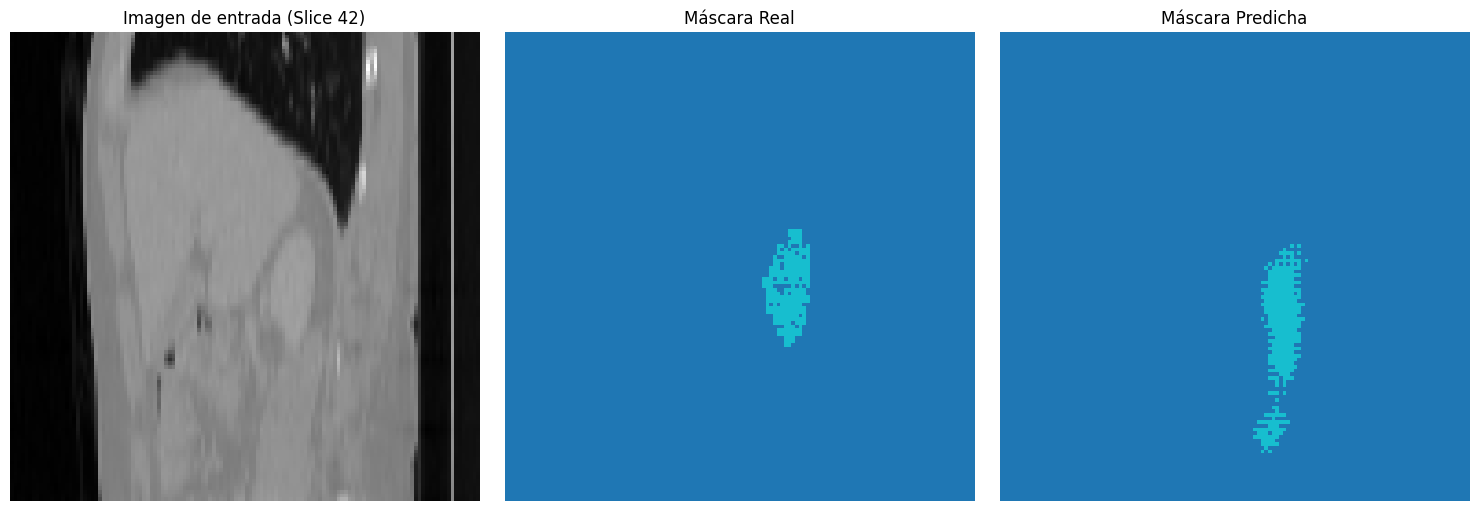

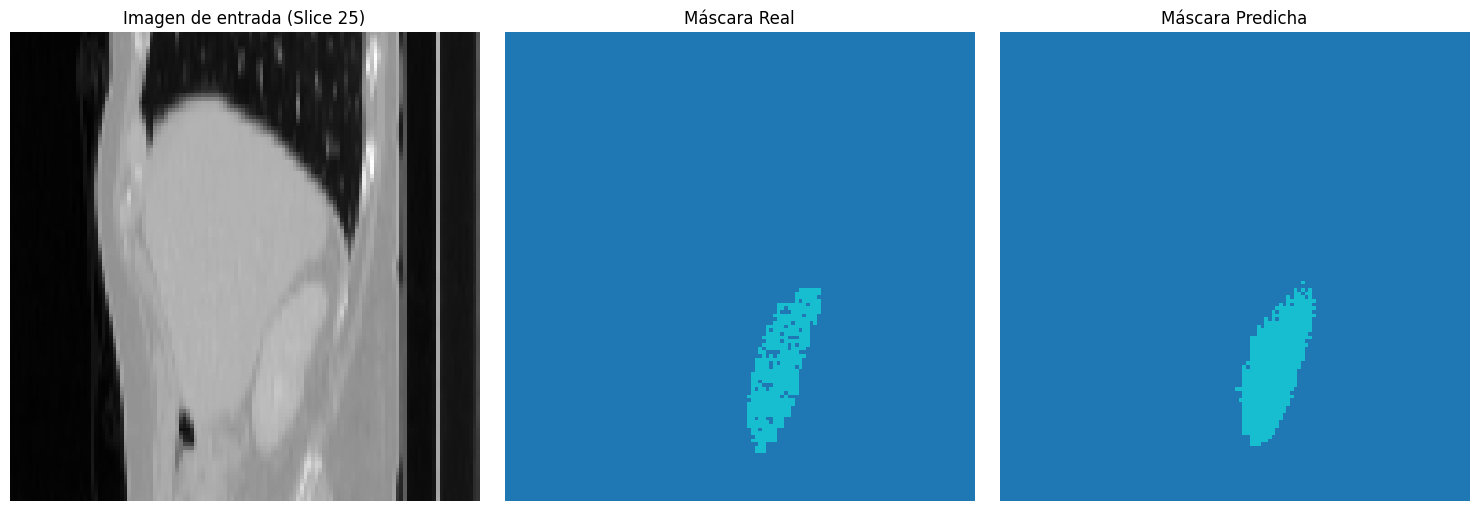

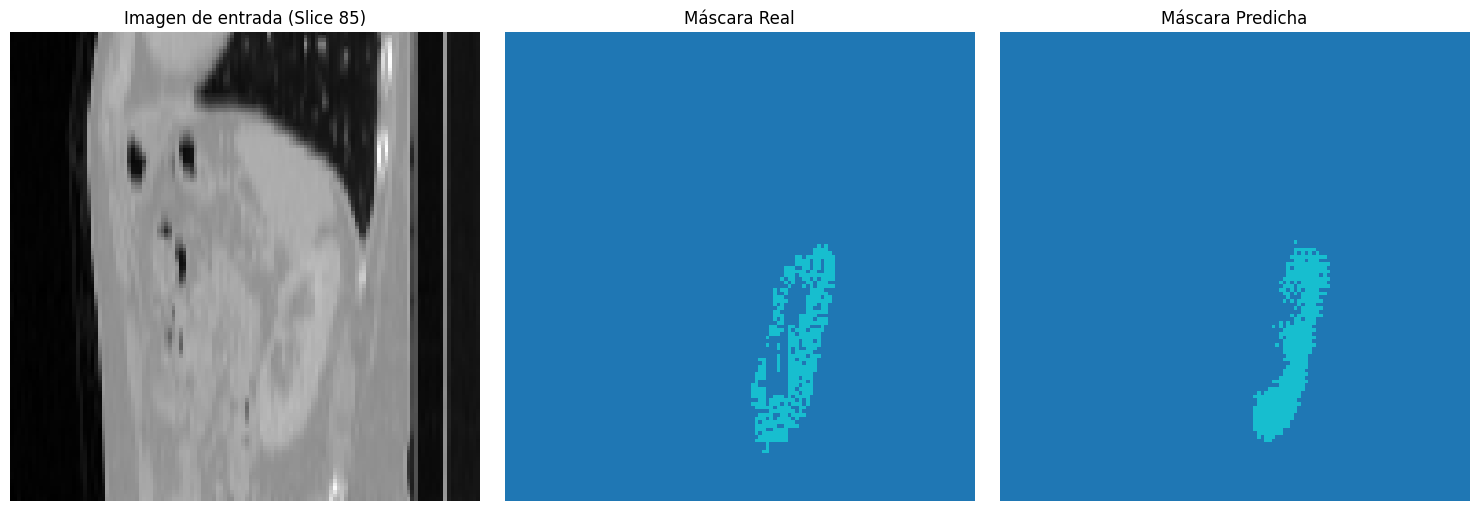

In [119]:
visualize_multiple_slices(model, test_dataset, index=0)


Este código tiene como propóstito superponer la máscara predicha sobre la imagen original en un corte específico.

Funcionamiento del código:

1. Selección de slices:
  - Se extrae un slice específico de la imagen 3D, se utiliza `slice_idx` para seleccionar el corte a lo largo del eje Z.
  - Se normaliza para visualización.

  - Se extrae el mismo corte de la máscara predicha y se normaliza para adaptarse al colormap.

2. Aplicación del colormap:
  - La máscara predicha se transforma en un mapa de colores utilizando `tab10`:
    - Este colormap aplica colores categóricos diferenciables para valores en la máscara.
    - La máscara coloreada se convierte en un tensor RGB.

3. Superposición:

  - La máscara coloreada se combina con la imagen usando una fórmula de interporlación lineal:
    - `overlay = (1 - alpha) * imagen_original + alpha * máscara_coloreada`.
    - Esto permite que la máscara se dibuje encima de la imagen manteniendo detalles de ambas.

4. Visualización:
  - Se muestra la imagen original en escala de grises.
  - Se muestra la combinación de la imagen original con la máscara predicha usando opacidad.

In [120]:
def overlay_prediction_on_image(image, predicted_mask, slice_idx, alpha=0.5):
    # Convertir a numpy
    image_slice = image[0, 0, :, :, slice_idx].cpu().numpy()  # Imagen de entrada en escala de grises
    predicted_slice = predicted_mask[:, :, slice_idx].cpu().numpy()  # Máscara predicha

    # Normalizar la imagen para visualizar (0-1)
    image_slice = (image_slice - np.min(image_slice)) / (np.max(image_slice) - np.min(image_slice))

    # Aplicar un colormap a la máscara predicha
    cmap = plt.get_cmap("tab10")  # Cambia el colormap
    predicted_colored = cmap(predicted_slice / np.max(predicted_slice))  # Normalizar máscara
    predicted_colored = np.squeeze(predicted_colored)  # Eliminar dimensiones innecesarias

    # Superponer predicción sobre la imagen
    overlay = (1 - alpha) * image_slice[..., np.newaxis] + alpha * predicted_colored[..., :3]  # Mezclar RGB

    # Mostrar la imagen original y la superposición
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_slice, cmap="gray")
    plt.title(f"Imagen original (Slice {slice_idx})")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(overlay)
    plt.title("Superposición con predicción")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

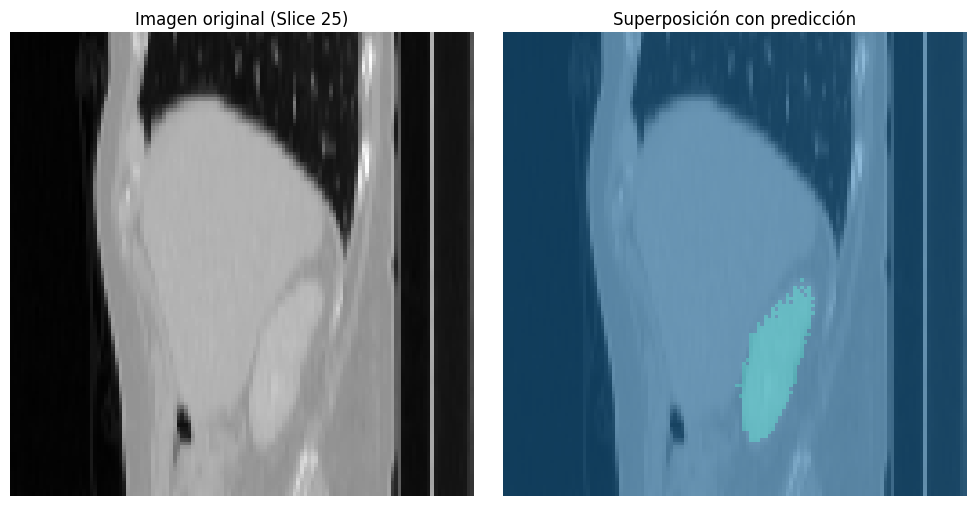

In [121]:
# Visualizar superposición para un slice específico
index = 0  # Índice del ejemplo en el dataset
slice_idx = 25  # Índice del slice a visualizar

# Obtener ejemplo del dataset
image, _ = test_dataset[index]  # Ignorar la máscara real
image = image.to("cuda" if torch.cuda.is_available() else "cpu").unsqueeze(0)  # Añadir dimensión del batch

# Generar predicción
model.eval()
with torch.no_grad():
    logits = model(image)
    predicted_mask = torch.argmax(logits, dim=1).squeeze(0)  # Elimina dimensión del batch

# Llamar a la función para visualizar
overlay_prediction_on_image(image, predicted_mask, slice_idx)

### U-Net con sobremuestreo y combinedLoss

In [122]:
# Entrenamiento
def train_model(model, train_loader, val_loader, epochs):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward
            outputs = model(images)
            #loss = loss_function(outputs, masks.squeeze(1).long())
            loss = combined_loss(outputs, masks.squeeze(1).long())
            # Usar Focal Loss
            #loss_function = lambda logits, targets: focal_loss(logits, targets, alpha=0.25, gamma=2)


            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validación
        model.eval()
        val_loss = 0.0
        all_metrics = {"IoU": [], "Dice": []}
        with torch.no_grad():
          for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            #loss = loss_function(outputs, masks.squeeze(1).long())
            loss = combined_loss(outputs, masks.squeeze(1).long())
            val_loss += loss.item()

            # Calcular métricas
            metrics = compute_metrics(outputs, masks.squeeze(1).long(), num_classes=4)
            all_metrics["IoU"].append(metrics["IoU"])
            all_metrics["Dice"].append(metrics["Dice"])

        # Promediar las métricas al final de la validación
        iou_mean = np.mean(all_metrics["IoU"], axis=0)
        dice_mean = np.mean(all_metrics["Dice"], axis=0)
        print(f"Val IoU: {iou_mean}, Val Dice: {dice_mean}")
        # Ajustar el learning rate
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

    return model

#loss_function = lambda logits, targets: focal_loss(logits, targets, alpha=0.25, gamma=2)

# Evaluar el modelo
train_model(model, train_loader=train_loader,
    val_loader=val_loader,
    epochs=20)

Val IoU: [9.94296670e-01 3.87995984e-01 7.06060613e-04 0.00000000e+00], Val Dice: [0.99713885 0.55523147 0.00140297 0.        ]
Epoch 1/20, Train Loss: 0.3736, Val Loss: 0.3196
Val IoU: [9.95127628e-01 4.73927728e-01 2.37567860e-02 1.87282745e-06], Val Dice: [9.97556938e-01 6.40050638e-01 4.14864620e-02 3.74552878e-06]
Epoch 2/20, Train Loss: 0.3091, Val Loss: 0.2976
Val IoU: [0.99558789 0.50328278 0.01127243 0.        ], Val Dice: [0.99778737 0.66520169 0.02033383 0.        ]
Epoch 3/20, Train Loss: 0.2708, Val Loss: 0.3016
Val IoU: [0.99557419 0.49632916 0.01493674 0.        ], Val Dice: [0.99778047 0.65894562 0.02640497 0.        ]
Epoch 4/20, Train Loss: 0.2372, Val Loss: 0.2938
Val IoU: [9.95775888e-01 5.25221494e-01 2.03319216e-02 1.87213332e-05], Val Dice: [9.97881704e-01 6.84344603e-01 3.62861771e-02 3.74300515e-05]
Epoch 5/20, Train Loss: 0.2189, Val Loss: 0.2956
Val IoU: [0.99580732 0.52481786 0.02287376 0.        ], Val Dice: [0.99789755 0.68363034 0.0400549  0.        ]
Epo

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, aff

In [123]:
test_metrics = evaluate_model(model, test_loader, num_classes=4)

Average IoU: [9.93614810e-01 4.63940712e-01 2.44981169e-02 4.20662968e-05]
Average Dice: [9.96793046e-01 6.27387600e-01 4.53567587e-02 8.40583373e-05]


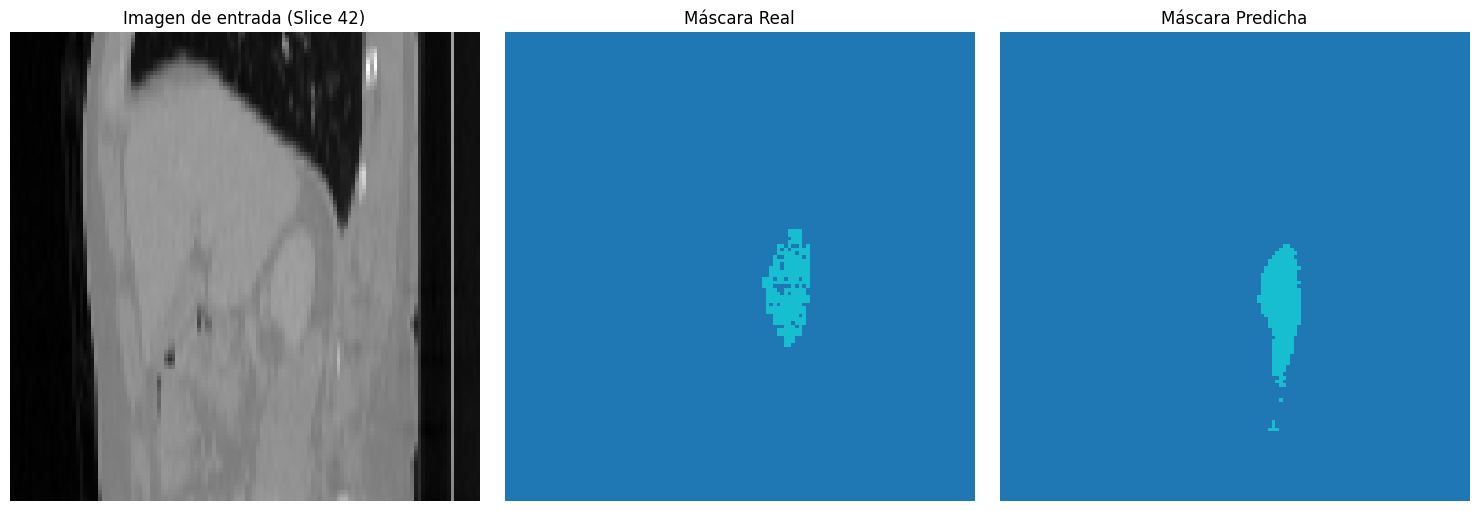

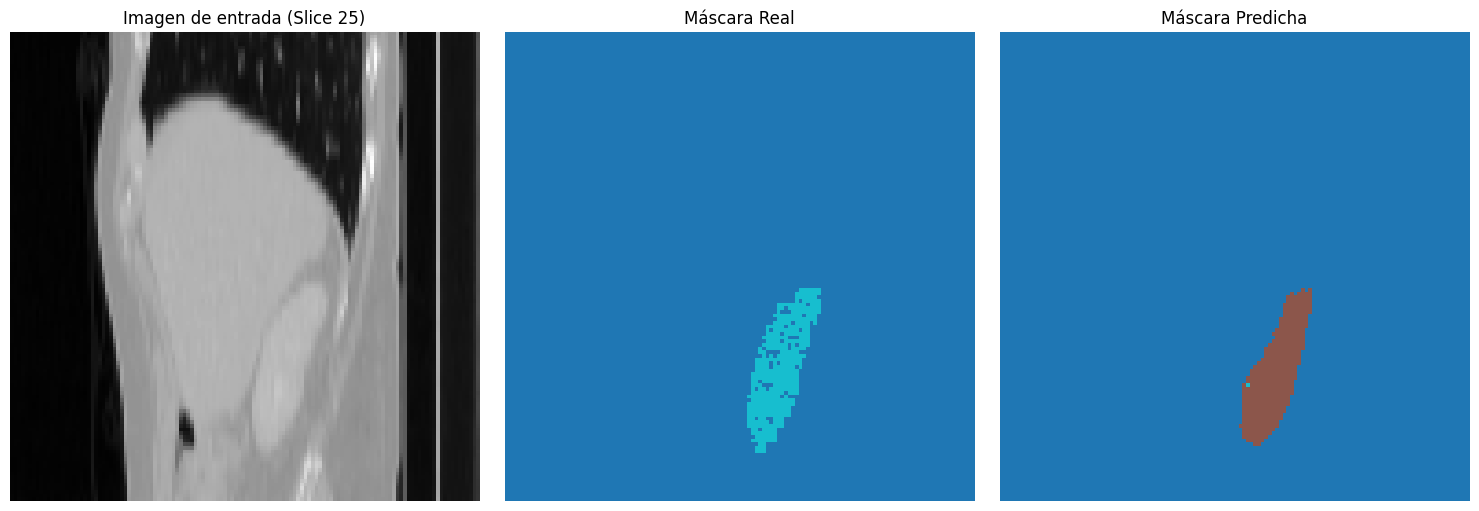

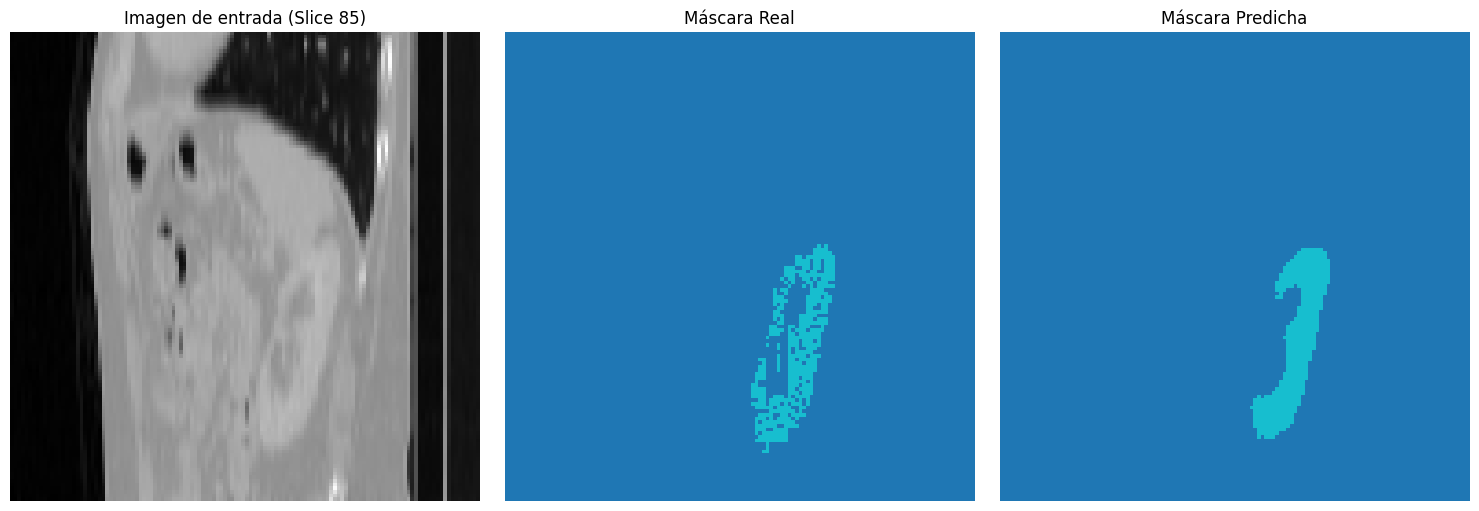

In [124]:
visualize_multiple_slices(model, test_dataset, index=0)

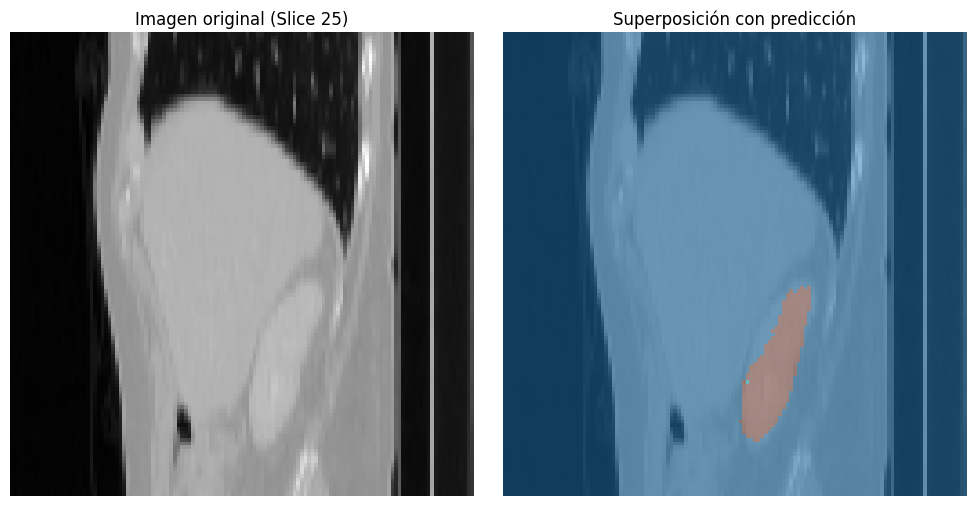

In [125]:
# Visualizar superposición para un slice específico
index = 0  # Índice del ejemplo en el dataset
slice_idx = 25  # Índice del slice a visualizar

# Obtener ejemplo del dataset
image, _ = test_dataset[index]  # Ignorar la máscara real
image = image.to("cuda" if torch.cuda.is_available() else "cpu").unsqueeze(0)  # Añadir dimensión del batch

# Generar predicción
model.eval()
with torch.no_grad():
    logits = model(image)
    predicted_mask = torch.argmax(logits, dim=1).squeeze(0)  # Elimina dimensión del batch

# Llamar a la función para visualizar
overlay_prediction_on_image(image, predicted_mask, slice_idx)

## VNet de Monai

In [53]:
# Check if Google Drive is already mounted
# if not os.path.exists('/content/drive'):
#   drive.mount('/content/drive')  # Mount only if it's not already mounted
# else:
#   print("Google Drive is already mounted")
# preprocessed2_path = '/content/drive/MyDrive/preprocessed/'

# if os.path.exists(preprocessed2_path):
#     print(f"El directorio {preprocessed2_path} existe.")
# else:
#     print(f"El directorio {preprocessed2_path} no existe. Creándolo...")

# #os.makedirs(preprocessed_path, exist_ok=True)

# count = sum([len(files) for _, _, files in os.walk(preprocessed2_path)])
# print(f"Archivos en preprocessed_path: {count}")


In [130]:
#Importar ruta del servidor 
import os

# Definir el path de las imágenes del dataset 3D 
preprocessed2_path = '/mnt/homeGPU/mcribilles/proy_final/preprocessed'


# Comprobar que existe la ruta o crearla
os.makedirs(preprocessed2_path, exist_ok=True)

# Mostrar cantidad de elementos en la carpeta
num_elements = len(os.listdir(preprocessed2_path))
print(f"Cantidad de elementos en la carpeta '{preprocessed2_path}': {num_elements}")

Cantidad de elementos en la carpeta '/mnt/homeGPU/mcribilles/proy_final/preprocessed': 976


### Usando sobremuestreo y combinedLoss

In [208]:
# Crear Datasets
train_dataset = PreprocessedDataset(preprocessed2_path, train_cases)
val_dataset = PreprocessedDataset(preprocessed2_path, val_cases)
test_dataset = PreprocessedDataset(preprocessed2_path, test_cases)

**Sobremuestreo de imágenes 3D**

In [209]:
# Definit train pairs como pares imagen, mascara del train_dataset
train_pairs = [(train_dataset[i][0], train_dataset[i][1]) for i in range(len(train_dataset))]

In [210]:
# Contamos cuántos ejemplos hay de cada clase
from collections import Counter
# Contar muestras por clase en el conjunto de entrenamiento
no_of_classes=4
class_counts = Counter()
for _, masks in train_loader:
    for mask in masks:
        unique, counts = torch.unique(mask, return_counts=True)
        class_counts.update(dict(zip(unique.cpu().numpy(), counts.cpu().numpy())))

samples_per_cls = [class_counts[i] for i in range(no_of_classes)]


In [211]:
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

class_counts = [701371044, 4110016, 1202869, 56295]

# Calcular pesos para realizar sobremuestreo
class_weights = [0,0,0,0]
for i in range(len(class_counts)):
    class_weights[i] = 1.0 / class_counts[i]

sample_weights = []
for _, mask in tqdm(train_pairs):
    # mask = load_mask(mask_path).numpy()
    unique, counts = np.unique(mask, return_counts=True)
    weight = sum(class_weights[int(cls)] * count for cls, count in zip(unique, counts))
    sample_weights.append(weight.item())

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

100%|██████████| 337/337 [00:13<00:00, 25.05it/s]


In [212]:
# Crear DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [235]:
from monai.networks.nets import VNet

# Modelo VNet para segmentación 3D
model = VNet(
    spatial_dims=3,         # 3D convoluciones
    in_channels=1,          # Número de canales de entrada (e.g., 1 para imágenes médicas)
    out_channels=4,         # Número de clases de salida para la segmentación
    act=("relu", {"inplace": True}),  # Función de activación
).to("cuda" if torch.cuda.is_available() else "cpu")

# Resumen del modelo
print(model)

VNet(
  (in_tr): InputTransition(
    (act_function): ReLU(inplace=True)
    (conv_block): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (down_tr32): DownTransition(
    (down_conv): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_function1): ReLU(inplace=True)
    (act_function2): ReLU(inplace=True)
    (ops): Sequential(
      (0): LUConv(
        (act_function): ReLU(inplace=True)
        (conv_block): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )


In [236]:
# Entrenamiento
loss_function = lambda logits, targets: combined_loss(logits, targets)
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    loss_function=loss_function
    )

Val IoU: [0.01942882 0.00229146 0.00048786 0.00071694], Val Dice: [0.03810973 0.00456996 0.0009747  0.00142806]
Epoch 1/10, Train Loss: 1.2912, Val Loss: 1.2974
Val IoU: [0.03567226 0.00249394 0.00057773 0.00072631], Val Dice: [0.06879528 0.00497209 0.00115397 0.00144637]
Epoch 2/10, Train Loss: 1.2904, Val Loss: 1.2872
Val IoU: [0.0538056  0.00212989 0.00042607 0.00070593], Val Dice: [0.10195316 0.00424826 0.00085134 0.00140598]
Epoch 3/10, Train Loss: 1.2924, Val Loss: 1.2525
Val IoU: [0.04196914 0.00273258 0.00061685 0.00072839], Val Dice: [0.08037003 0.00544635 0.00123208 0.00145061]
Epoch 4/10, Train Loss: 1.2908, Val Loss: 1.2825
Val IoU: [0.0204658  0.00215915 0.00043689 0.00072268], Val Dice: [0.04010051 0.00430652 0.00087297 0.00143934]
Epoch 5/10, Train Loss: 1.2911, Val Loss: 1.2960
Val IoU: [0.02940568 0.0017427  0.0005249  0.0007354 ], Val Dice: [0.05711432 0.00347758 0.00104862 0.00146486]
Epoch 6/10, Train Loss: 1.2917, Val Loss: 1.2787
Val IoU: [0.05298479 0.00284281 0.

VNet(
  (in_tr): InputTransition(
    (act_function): ReLU(inplace=True)
    (conv_block): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
      (adn): ADN(
        (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (down_tr32): DownTransition(
    (down_conv): Conv3d(16, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2), bias=False)
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_function1): ReLU(inplace=True)
    (act_function2): ReLU(inplace=True)
    (ops): Sequential(
      (0): LUConv(
        (act_function): ReLU(inplace=True)
        (conv_block): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2), bias=False)
          (adn): ADN(
            (N): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
      )
    )


In [238]:
test_metrics = evaluate_model(model, test_loader, num_classes=4)

Average IoU: [0.03373218 0.00262254 0.00163575 0.0002631 ]
Average Dice: [0.06518199 0.00522894 0.00325839 0.0005258 ]


### Usando sobremuestreo y Focal Loss

In [213]:
loss_function = lambda logits, targets: focal_loss(logits, targets, alpha=0.25, gamma=2)
# Entrenamiento usando Focal loss
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    loss_function=loss_function
    )

Val IoU: [0.99155054 0.         0.         0.        ], Val Dice: [0.99575479 0.         0.         0.        ]
Epoch 1/10, Train Loss: 0.0104, Val Loss: 0.0041
Val IoU: [0.99269104 0.02719699 0.01157102 0.00225086], Val Dice: [0.99632984 0.05285845 0.02279831 0.00446299]
Epoch 2/10, Train Loss: 0.0035, Val Loss: 0.0023
Val IoU: [0.99303824 0.04108258 0.01216404 0.00110448], Val Dice: [0.9965047  0.0782069  0.02386363 0.00219882]
Epoch 3/10, Train Loss: 0.0023, Val Loss: 0.0016
Val IoU: [0.99350893 0.24775307 0.04198806 0.00187726], Val Dice: [0.99674232 0.39497897 0.07946742 0.00373793]
Epoch 4/10, Train Loss: 0.0017, Val Loss: 0.0013
Val IoU: [0.99376214 0.20564954 0.00533755 0.00144811], Val Dice: [0.99686929 0.33650952 0.01056509 0.0028877 ]
Epoch 5/10, Train Loss: 0.0014, Val Loss: 0.0010
Val IoU: [9.94416459e-01 3.59629051e-01 1.05166961e-02 6.66101140e-04], Val Dice: [0.99719877 0.52543876 0.02054384 0.0013289 ]
Epoch 6/10, Train Loss: 0.0011, Val Loss: 0.0009
Val IoU: [9.945693

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, aff

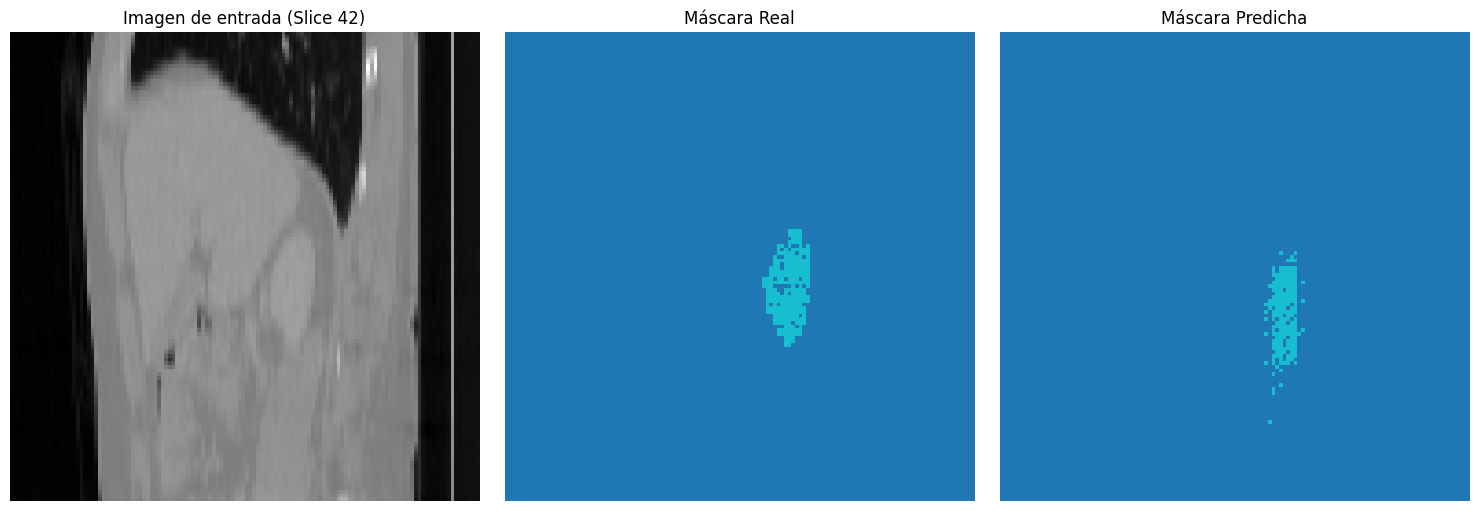

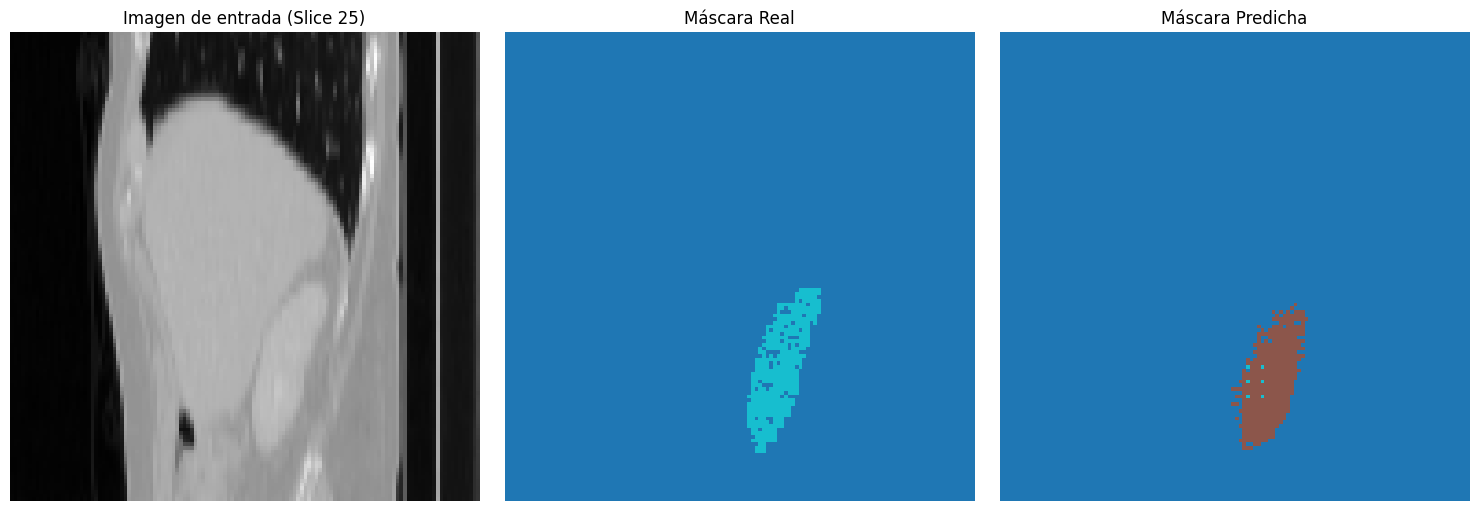

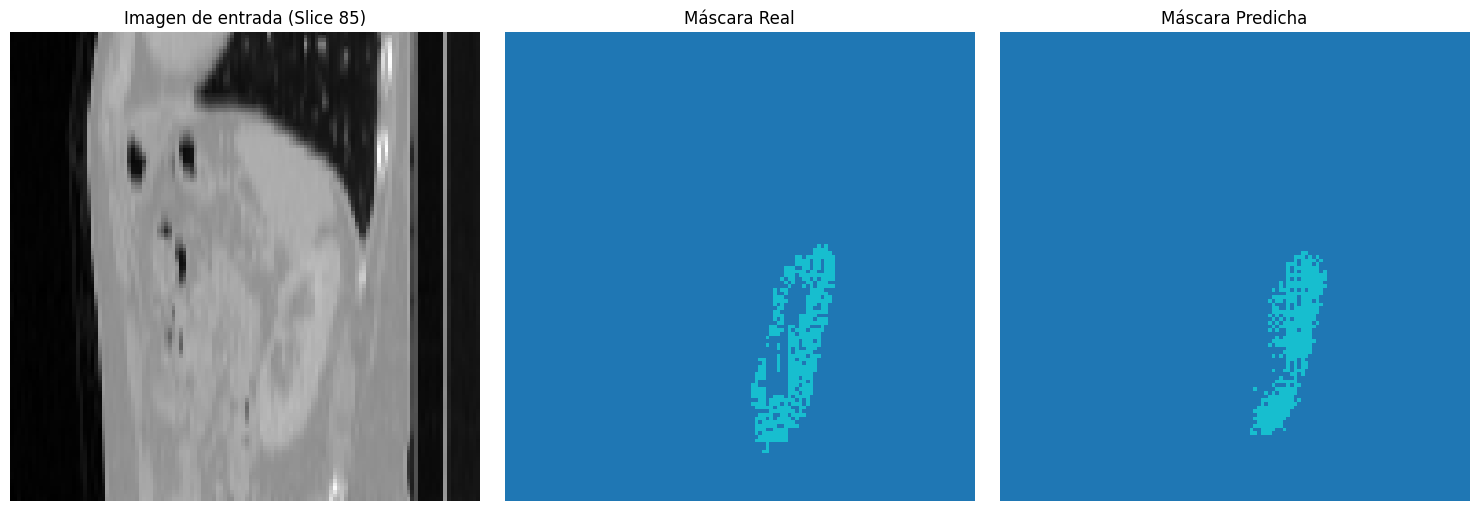

In [214]:
visualize_multiple_slices(model, test_dataset, index=0)

In [215]:
test_metrics = evaluate_model(model, test_loader, num_classes=4)

Average IoU: [9.93132004e-01 3.74261233e-01 4.41646695e-02 4.15523980e-05]
Average Dice: [9.96550523e-01 5.39497952e-01 7.12527622e-02 8.30323413e-05]


### Usando sobremuestreo y  CBLoss

In [216]:
# Crear DataLoaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [217]:
def focal2_loss(labels, logits, alpha, gamma):
    BCLoss = F.binary_cross_entropy_with_logits(input = logits, target = labels,reduction = "none")

    if gamma == 0.0:
        modulator = 1.0
    else:
        modulator = torch.exp(-gamma * labels * logits - gamma * torch.log(1 +
            torch.exp(-1.0 * logits)))

    loss = modulator * BCLoss

    weighted_loss = alpha * loss
    focal_loss = torch.sum(weighted_loss)

    focal_loss /= torch.sum(labels)
    return focal_loss


def CB_loss(labels, logits, samples_per_cls, no_of_classes, loss_type, beta, gamma, device):
    # Compute class weights
    effective_num = 1.0 - np.power(beta, samples_per_cls)
    weights = (1.0 - beta) / np.array(effective_num)
    weights = weights / np.sum(weights) * no_of_classes  # Normalize weights

    # Convert weights to a tensor and send to device
    weights = torch.tensor(weights, dtype=torch.float32, device=device)
    weights = weights.view(1, 1, 1, 1, -1)  # Expand dimensions to match labels_one_hot

    # One-hot encode labels and send to device
    labels_one_hot = F.one_hot(labels, no_of_classes).float().to(device)  # Shape: (batch_size, depth, height, width, no_of_classes)

    logits = logits.permute(0, 2, 3, 4, 1)
    # Expand weights to match the shape of labels_one_hot
    weights = weights.repeat(
        labels_one_hot.shape[0],  # Batch size
        labels_one_hot.shape[1],  # Depth
        labels_one_hot.shape[2],  # Height
        labels_one_hot.shape[3],  # Width
        1                        # Number of classes
    )

    # Apply weights to one-hot labels
    weights = weights * labels_one_hot
    weights = weights.sum(-1)  # Sum over the class dimension
    weights = weights.unsqueeze(-1).repeat(1, 1, 1, 1, no_of_classes)  # Expand back for loss computation

    # Compute loss
    if loss_type == "focal":
        cb_loss = focal2_loss(labels_one_hot, logits, weights, gamma)
    elif loss_type == "sigmoid":
        cb_loss = F.binary_cross_entropy_with_logits(input=logits, target=labels_one_hot, weight=weights)
    elif loss_type == "softmax":
        pred = logits.softmax(dim=1)
        cb_loss = F.binary_cross_entropy(input=pred, target=labels_one_hot, weight=weights)

    return cb_loss


In [218]:
# Parámetros para CB_loss
no_of_classes = 4
beta = 0.9999
gamma = 2.0
loss_type = "focal"
samples_per_cls = [701371044, 4110016, 1202869, 56295]

In [219]:
# Definir CB_loss como función de pérdida
device = "cuda" if torch.cuda.is_available() else "cpu"
def loss_function(logits, targets):
    return CB_loss(
        labels=targets,
        logits=logits,
        samples_per_cls=samples_per_cls,
        no_of_classes=no_of_classes,
        loss_type=loss_type,
        beta=beta,
        gamma=gamma,
        device=device
    )

In [220]:
# Entrenamiento usando CB_loss
train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    loss_function=loss_function
    )

Val IoU: [0.99452869 0.07349848 0.06323214 0.0028026 ], Val Dice: [0.99725502 0.13632504 0.11619041 0.00556163]
Epoch 1/10, Train Loss: 0.0782, Val Loss: 0.0324
Val IoU: [0.99431699 0.06450282 0.07301807 0.0015809 ], Val Dice: [0.99714844 0.12044951 0.13145128 0.00314487]
Epoch 2/10, Train Loss: 0.0269, Val Loss: 0.0212
Val IoU: [9.94934317e-01 1.94786013e-01 7.29570561e-02 6.57549550e-04], Val Dice: [0.99745866 0.32293981 0.13132702 0.0013123 ]
Epoch 3/10, Train Loss: 0.0194, Val Loss: 0.0166
Val IoU: [9.95072348e-01 2.77698986e-01 7.79582151e-02 9.41834118e-05], Val Dice: [9.97528444e-01 4.29996834e-01 1.37955320e-01 1.88167207e-04]
Epoch 4/10, Train Loss: 0.0164, Val Loss: 0.0141
Val IoU: [9.95010889e-01 3.44754695e-01 5.07668135e-02 9.17904617e-05], Val Dice: [9.97497383e-01 5.06162088e-01 9.32292895e-02 1.83333541e-04]
Epoch 5/10, Train Loss: 0.0130, Val Loss: 0.0130
Val IoU: [9.95583786e-01 4.22258411e-01 9.26748646e-02 2.84754226e-05], Val Dice: [9.97785499e-01 5.86946817e-01 1.

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, aff

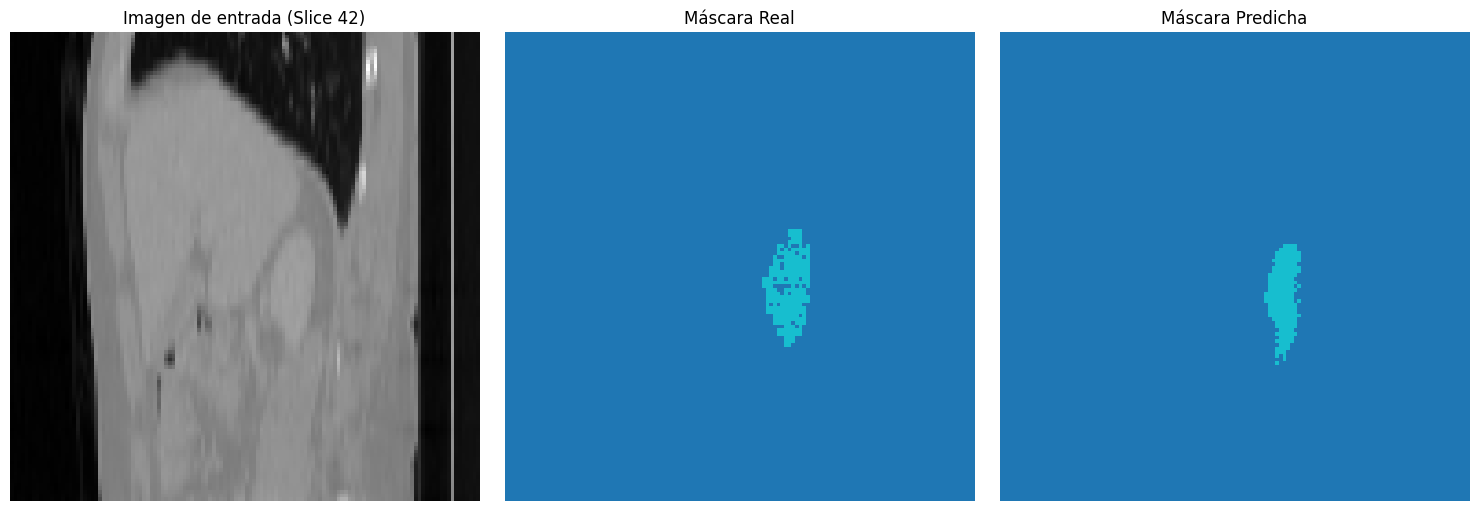

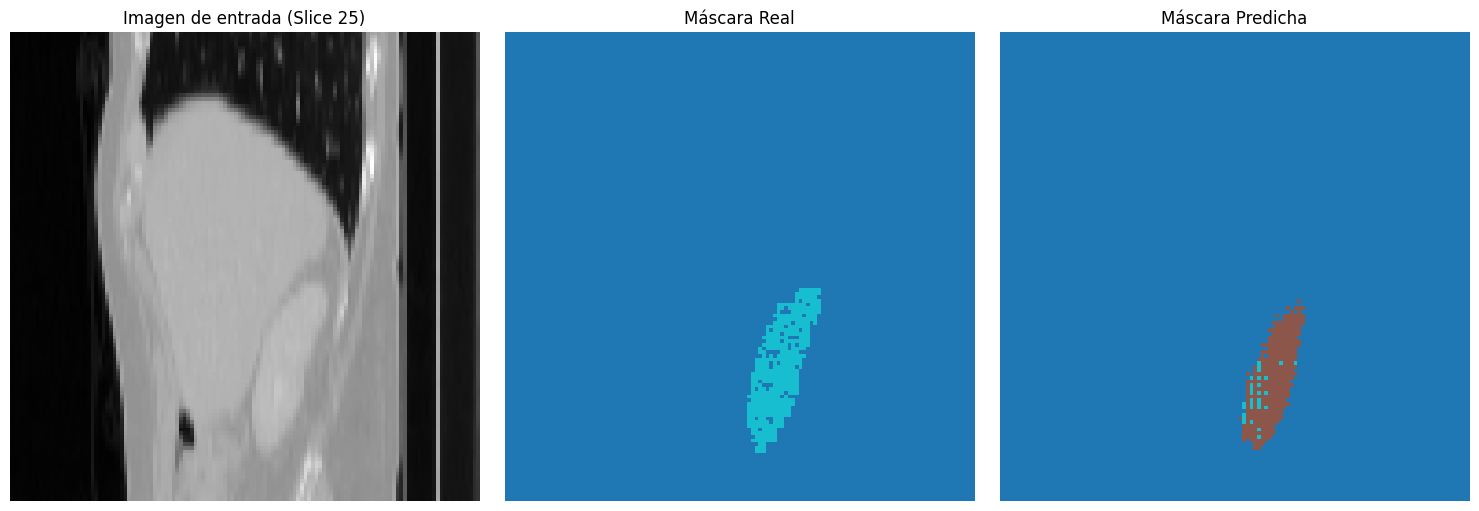

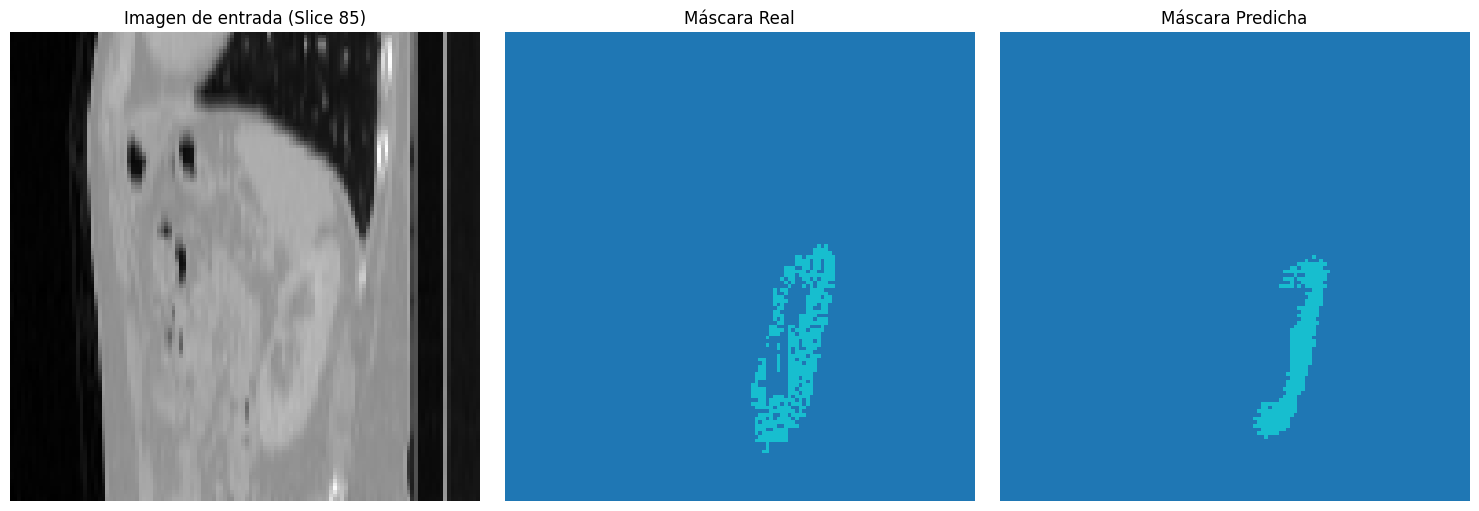

In [221]:
visualize_multiple_slices(model, test_dataset, index=0)

In [222]:
test_metrics = evaluate_model(model, test_loader, num_classes=4)

Average IoU: [0.99375843 0.41176429 0.09340234 0.        ]
Average Dice: [0.99686601 0.57731291 0.15462842 0.        ]


Con todas los resultados obtenidos, vemos que U-Net tiene un mejor rendimiento en la segmentación de riñones (Dice: 0.6274) pero pobre en tumores (Dice: 0.0454) y quistes (Dice: 0.0001). Por otro lado, V-Net el desempeño inferior en riñones (mejor Dice: 0.5773 con CB Loss) pero ligera mejora en tumores (Dice: 0.1546 con CB Loss), pero mo detecta de quistes. SegResNet es variable según la función de pérdida: es mejor en tumores con Focal Loss Weighted (Dice: 0.2344) y quistes (aunque muy bajo, Dice: 0.0065), también CB Loss logra mejor balance en riñones (Dice: 0.5938).

## SEGRESNET

In [ ]:
# preprocessed2_path = '/content/drive/MyDrive/kits23/preprocessed/'

# # Obtener los archivos de la carpeta
# image_files = [
#     f for f in os.listdir(preprocessed2_path) if f.endswith(('.npy', '.nii.gz'))
# ]

In [166]:
# Crear DataLoaders
batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [167]:
# Configurar el modelo SegResNet
model = SegResNet(
    spatial_dims=3,
    in_channels=1,    # Entrada: imágenes en escala de grises
    out_channels=4,   # Salida: 4 clases de segmentación
    init_filters=32,  # Filtros iniciales
    blocks_down=[1, 2, 2, 4],  # Número de bloques en cada etapa del encoder
    blocks_up=[1, 1, 1]        # Número de bloques en el decoder
).to("cuda" if torch.cuda.is_available() else "cpu")

In [168]:
# Misma inicialización que en Unet pero con uniforme de Xavier
def initialize_weights_x(m):
    if isinstance(m, (nn.Conv3d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm3d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

# Aplicar inicialización
model.apply(initialize_weights_x)


SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 64, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 64, eps=1e-05, a

### FineTuning

In [169]:
# Congelar el encoder (primeras capas)
for name, param in model.named_parameters():
    if "down" in name:  # Bloques del encoder están etiquetados como "down"
        param.requires_grad = False

# Confirmar qué partes están congeladas
for name, param in model.named_parameters():
    print(f"{name}: {'Trainable' if param.requires_grad else 'Frozen'}")


convInit.conv.weight: Trainable
down_layers.0.1.norm1.weight: Frozen
down_layers.0.1.norm1.bias: Frozen
down_layers.0.1.norm2.weight: Frozen
down_layers.0.1.norm2.bias: Frozen
down_layers.0.1.conv1.conv.weight: Frozen
down_layers.0.1.conv2.conv.weight: Frozen
down_layers.1.0.conv.weight: Frozen
down_layers.1.1.norm1.weight: Frozen
down_layers.1.1.norm1.bias: Frozen
down_layers.1.1.norm2.weight: Frozen
down_layers.1.1.norm2.bias: Frozen
down_layers.1.1.conv1.conv.weight: Frozen
down_layers.1.1.conv2.conv.weight: Frozen
down_layers.1.2.norm1.weight: Frozen
down_layers.1.2.norm1.bias: Frozen
down_layers.1.2.norm2.weight: Frozen
down_layers.1.2.norm2.bias: Frozen
down_layers.1.2.conv1.conv.weight: Frozen
down_layers.1.2.conv2.conv.weight: Frozen
down_layers.2.0.conv.weight: Frozen
down_layers.2.1.norm1.weight: Frozen
down_layers.2.1.norm1.bias: Frozen
down_layers.2.1.norm2.weight: Frozen
down_layers.2.1.norm2.bias: Frozen
down_layers.2.1.conv1.conv.weight: Frozen
down_layers.2.1.conv2.conv

In [170]:
# === Configuración del optimizador ===
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

### Usando sobremuestreo y combined loss

In [171]:
loss_function = lambda logits, targets: combined_loss(logits, targets)
fine_tuned_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    loss_function=loss_function
    )

Val IoU: [0.9927419 0.        0.        0.       ], Val Dice: [0.9963548 0.        0.        0.       ]
Epoch 1/20, Train Loss: 0.4182, Val Loss: 0.3664
Val IoU: [0.9927419 0.        0.        0.       ], Val Dice: [0.9963548 0.        0.        0.       ]
Epoch 2/20, Train Loss: 0.3835, Val Loss: 0.3607
Val IoU: [0.9927419 0.        0.        0.       ], Val Dice: [0.9963548 0.        0.        0.       ]
Epoch 3/20, Train Loss: 0.3755, Val Loss: 0.3574
Val IoU: [0.9927419 0.        0.        0.       ], Val Dice: [0.9963548 0.        0.        0.       ]
Epoch 4/20, Train Loss: 0.3750, Val Loss: 0.3555
Val IoU: [0.9927419 0.        0.        0.       ], Val Dice: [0.9963548 0.        0.        0.       ]
Epoch 5/20, Train Loss: 0.3763, Val Loss: 0.3530
Val IoU: [0.9931042  0.10117574 0.         0.        ], Val Dice: [0.99653734 0.17781761 0.         0.        ]
Epoch 6/20, Train Loss: 0.3611, Val Loss: 0.3292
Val IoU: [9.92860373e-01 3.30015037e-02 8.60585166e-05 0.00000000e+00], Va

In [172]:
test_metrics = evaluate_model(fine_tuned_model, test_loader, num_classes=4)

Average IoU: [0.99273935 0.4130403  0.01066493 0.        ]
Average Dice: [0.99634646 0.5727898  0.01753887 0.        ]


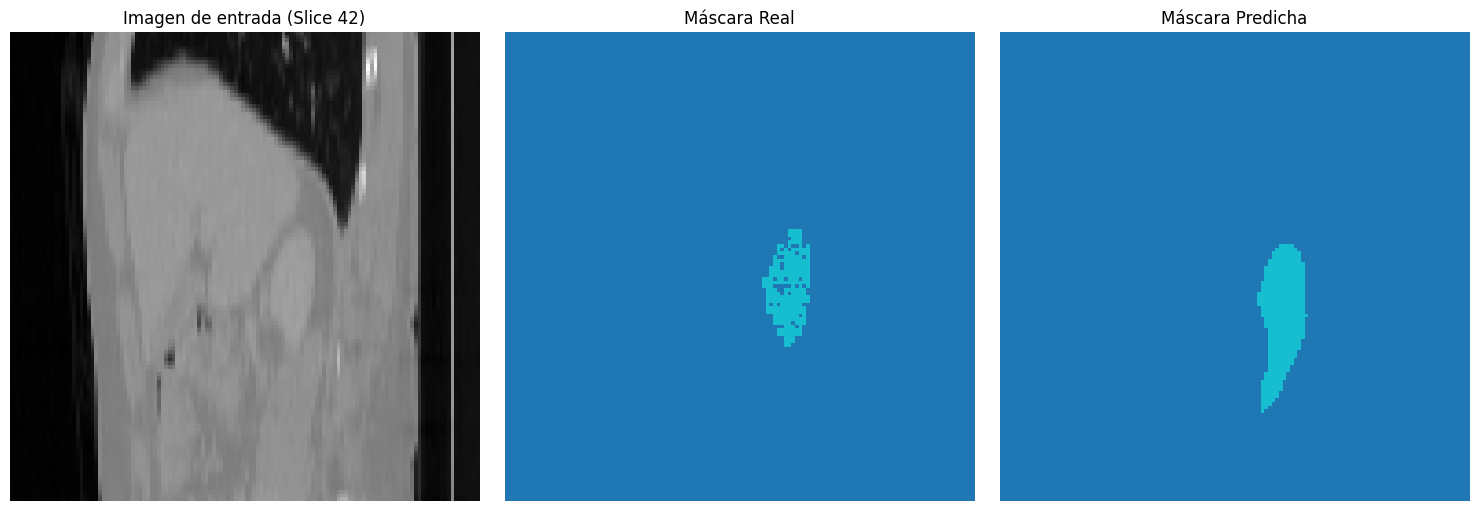

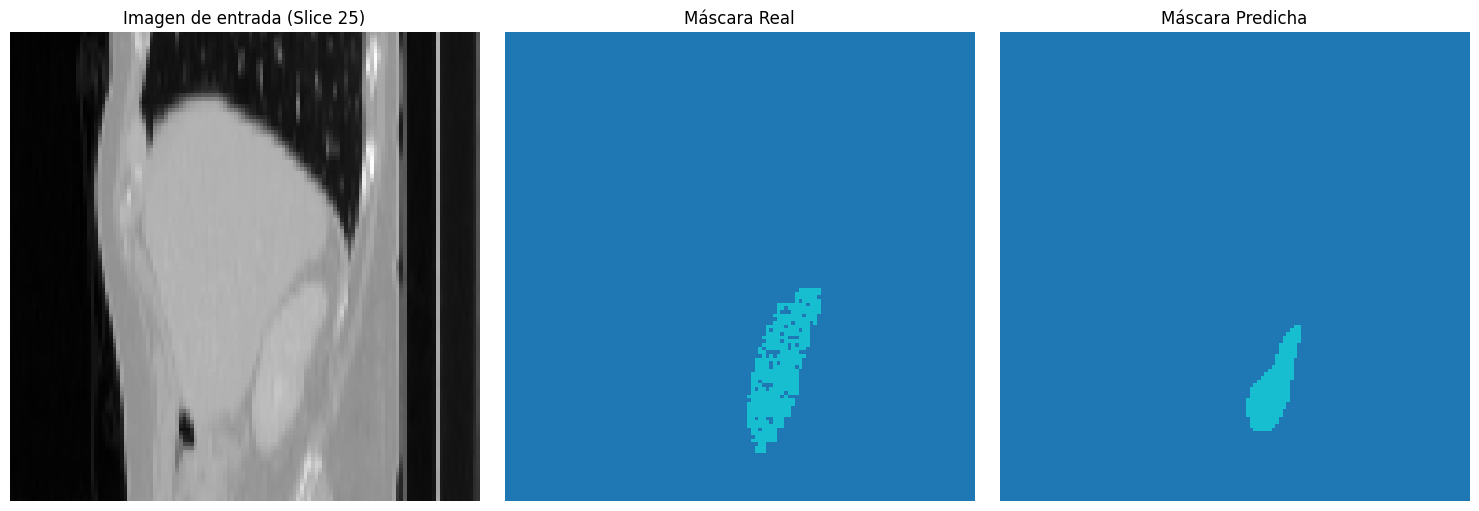

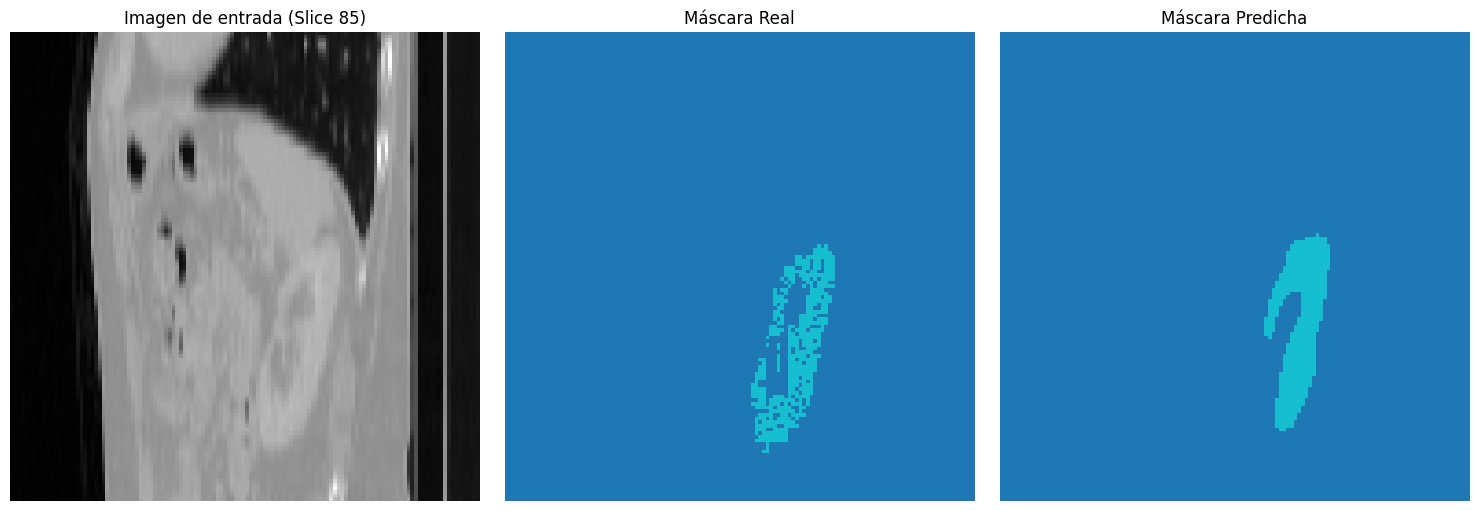

In [173]:
visualize_multiple_slices(model, test_dataset, index=0)

### Usando sobremuestreo y focal loss

In [174]:
loss_function = lambda logits, targets: focal_loss(logits, targets, alpha=0.25, gamma=2)
fine_tuned_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    loss_function=loss_function
    )

Val IoU: [0.99511711 0.4526921  0.00837702 0.        ], Val Dice: [0.99755081 0.61423217 0.01542226 0.        ]
Epoch 1/20, Train Loss: 0.0006, Val Loss: 0.0005
Val IoU: [0.99508822 0.48004821 0.00615663 0.        ], Val Dice: [0.99753644 0.64217741 0.01169216 0.        ]
Epoch 2/20, Train Loss: 0.0005, Val Loss: 0.0005
Val IoU: [0.99512739 0.4668328  0.00752649 0.        ], Val Dice: [0.99755605 0.62913522 0.01410707 0.        ]
Epoch 3/20, Train Loss: 0.0005, Val Loss: 0.0005
Val IoU: [0.9951458  0.47124098 0.01239859 0.        ], Val Dice: [0.99756541 0.63343938 0.02273115 0.        ]
Epoch 4/20, Train Loss: 0.0005, Val Loss: 0.0005
Val IoU: [0.99517257 0.48118429 0.01020222 0.        ], Val Dice: [0.99757883 0.64306934 0.01877227 0.        ]
Epoch 5/20, Train Loss: 0.0005, Val Loss: 0.0005
Val IoU: [0.99508351 0.4803495  0.01088727 0.        ], Val Dice: [0.99753419 0.64216389 0.0198669  0.        ]
Epoch 6/20, Train Loss: 0.0005, Val Loss: 0.0005
Val IoU: [0.99520407 0.48274535 0.

In [175]:
test_metrics = evaluate_model(fine_tuned_model, test_loader, num_classes=4)

Average IoU: [0.99336112 0.42197721 0.09282011 0.        ]
Average Dice: [0.99666078 0.57782955 0.14621498 0.        ]


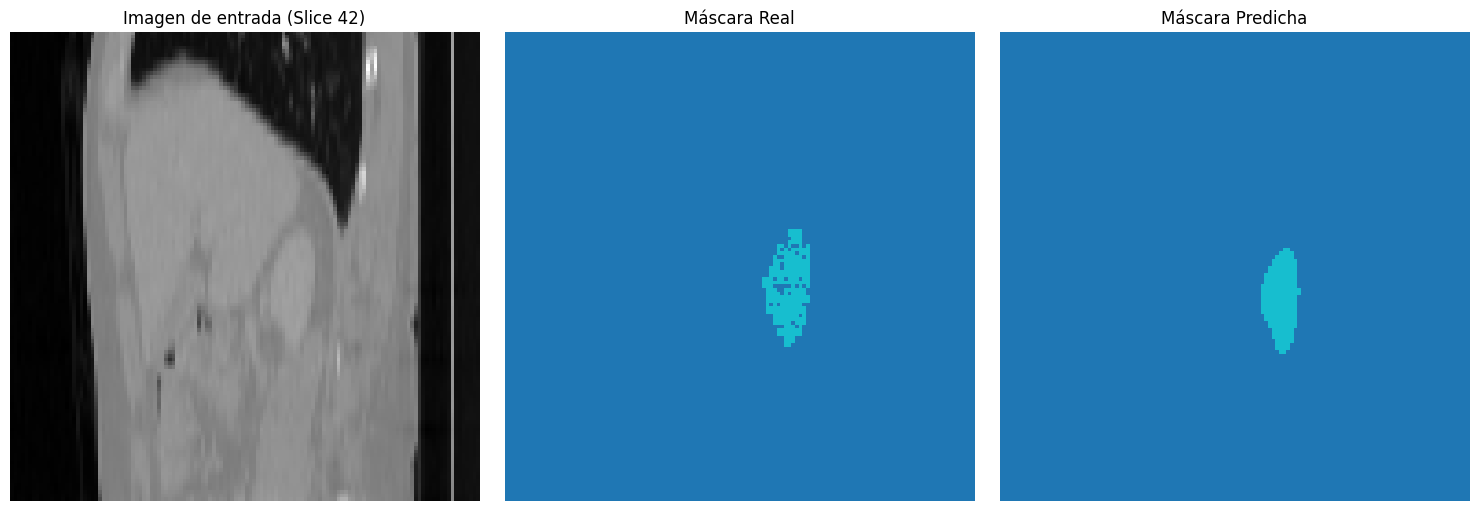

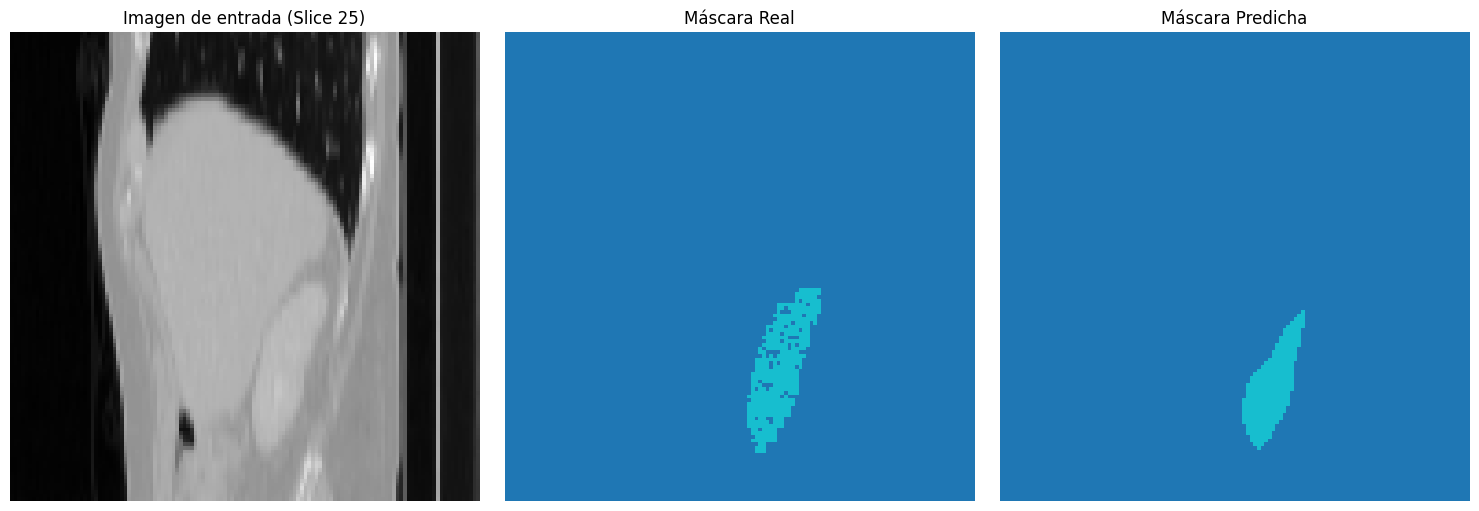

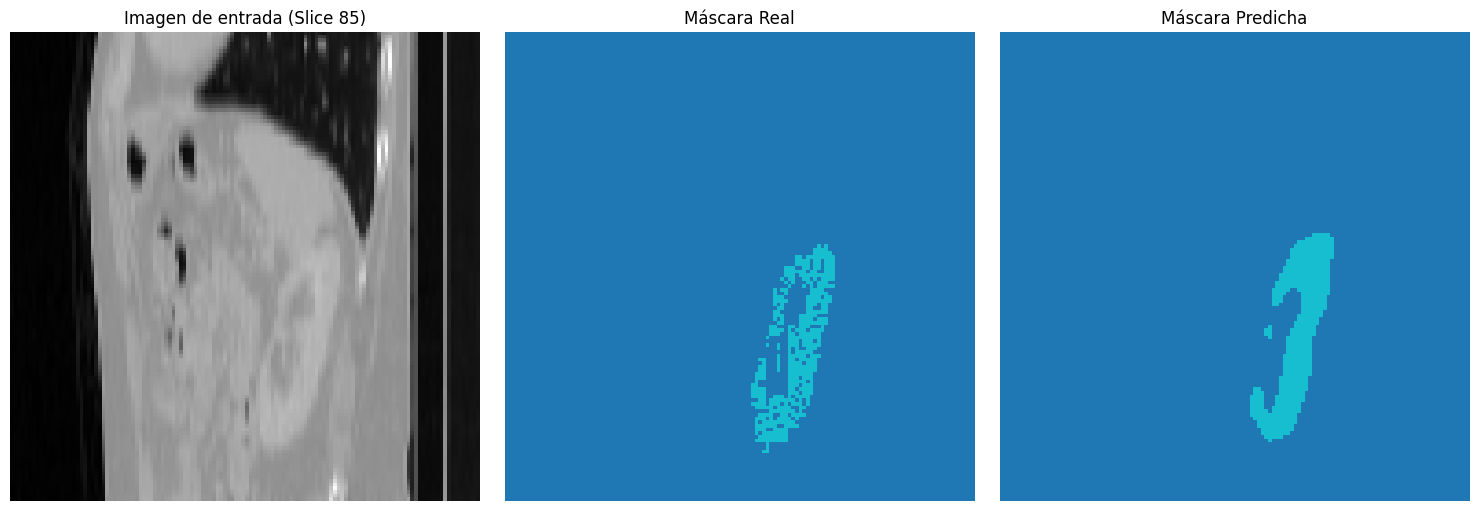

In [176]:
visualize_multiple_slices(model, test_dataset, index=0)

### Usando sobremuestreo y CBloss

In [178]:
def loss_function(logits, targets):
    return CB_loss(
        labels=targets,
        logits=logits,
        samples_per_cls=samples_per_cls,
        no_of_classes=no_of_classes,
        loss_type=loss_type,
        beta=beta,
        gamma=gamma,
        device=device
    )

# Entrenamiento usando CB_loss
fine_tuned_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    loss_function=loss_function
    )

Val IoU: [0.99310223 0.09344289 0.         0.        ], Val Dice: [0.99653627 0.16067992 0.         0.        ]
Epoch 1/20, Train Loss: 0.0214, Val Loss: 0.0130
Val IoU: [0.99329825 0.19641552 0.         0.        ], Val Dice: [0.99663565 0.32241468 0.         0.        ]
Epoch 2/20, Train Loss: 0.0165, Val Loss: 0.0146
Val IoU: [0.99477732 0.43073414 0.01230835 0.        ], Val Dice: [0.99738025 0.5960819  0.02239786 0.        ]
Epoch 3/20, Train Loss: 0.0143, Val Loss: 0.0100
Val IoU: [0.99478403 0.45170619 0.02257287 0.        ], Val Dice: [0.99738358 0.61703456 0.03861813 0.        ]
Epoch 4/20, Train Loss: 0.0108, Val Loss: 0.0100
Val IoU: [0.99499158 0.45686971 0.01189335 0.        ], Val Dice: [0.99748756 0.62100145 0.02160472 0.        ]
Epoch 5/20, Train Loss: 0.0109, Val Loss: 0.0095
Val IoU: [9.95033898e-01 4.60194362e-01 8.63115649e-04 0.00000000e+00], Val Dice: [0.9975089  0.62132426 0.00170013 0.        ]
Epoch 6/20, Train Loss: 0.0105, Val Loss: 0.0097
Val IoU: [0.995242

In [179]:
test_metrics = evaluate_model(fine_tuned_model, test_loader, num_classes=4)

Average IoU: [0.99357544 0.43964443 0.08609828 0.        ]
Average Dice: [0.9967681  0.59380837 0.13394754 0.        ]


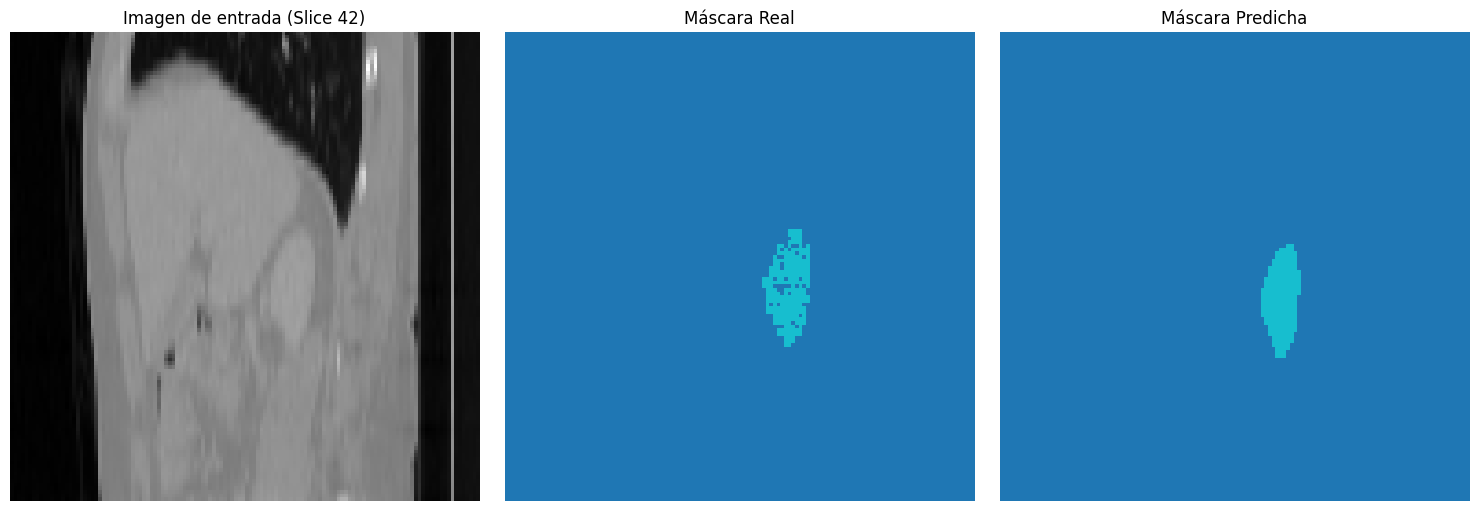

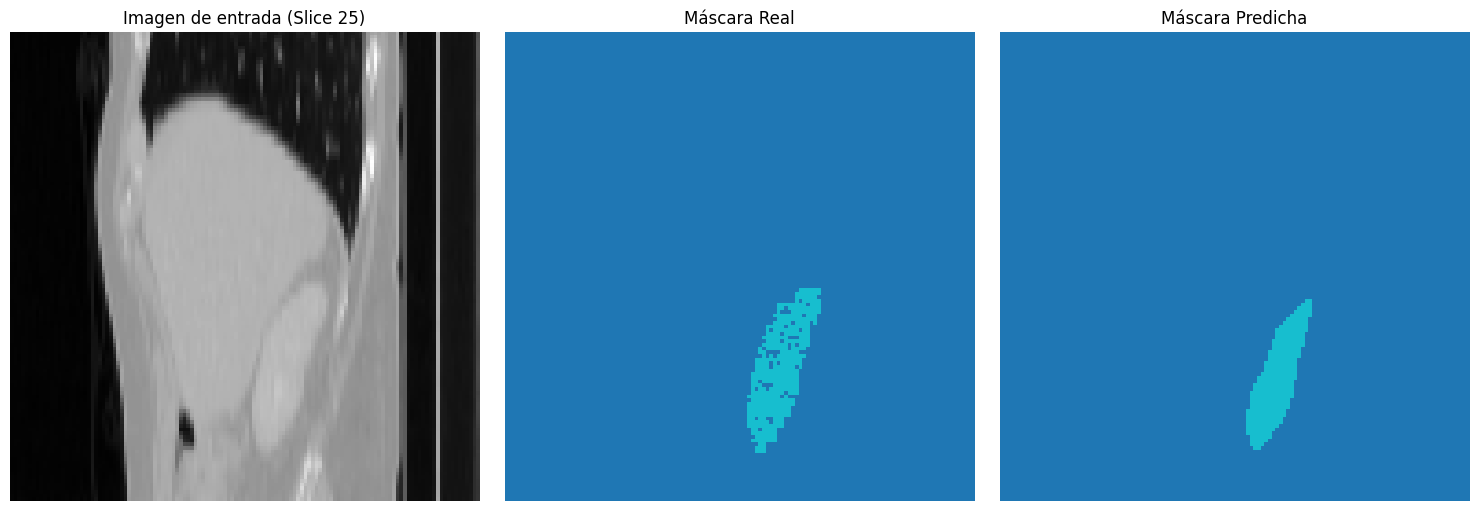

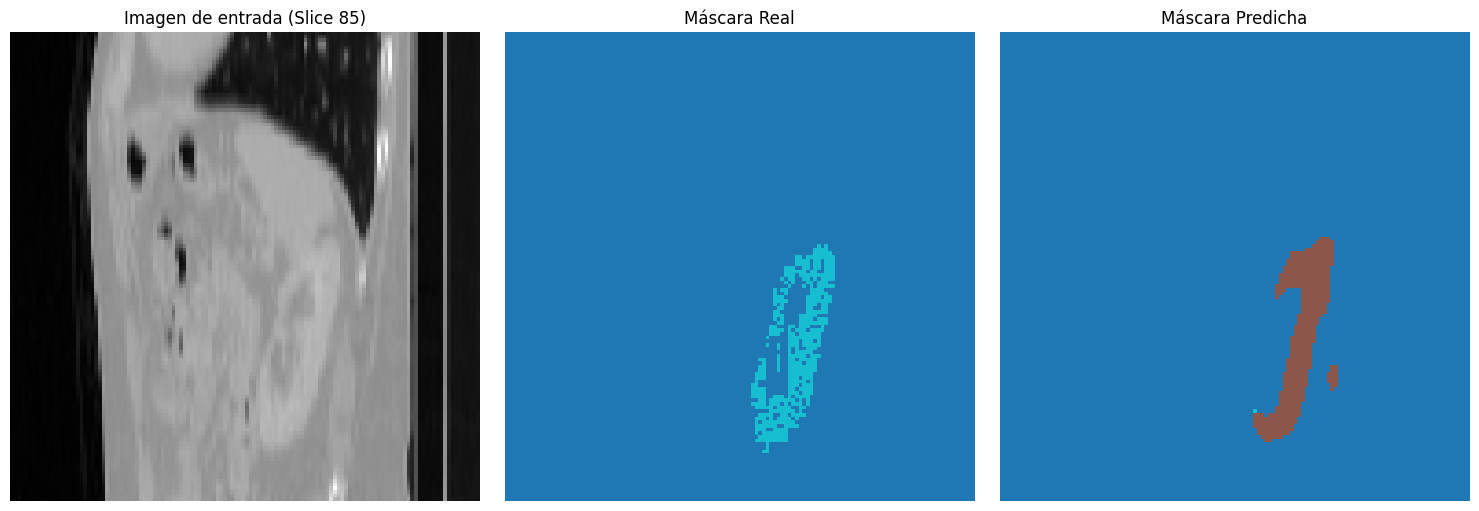

In [180]:
visualize_multiple_slices(model, test_dataset, index=0)

### Usando sobremuestreo y focal_loss_weighted

In [231]:
def focal_loss_weighted(logits, targets, class_weights, gamma=2):
    probas = torch.softmax(logits, dim=1)  # Convertir logits a probabilidades
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).permute(0, 4, 1, 2, 3).float()

    # Mover class_weights al mismo dispositivo 
    if class_weights is not None:
        class_weights = class_weights.to(device)

    # Expande los pesos de clase para igualar el tamaño de las predicciones
    class_weights = class_weights.view(1, -1, 1, 1, 1)  

    # Calcular el término focal y la pérdida
    focal_term = (1 - probas) ** gamma
    loss = -class_weights * focal_term * targets_one_hot * torch.log(probas + 1e-6)

    return loss.mean()

class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights /= class_weights.sum()  # Normalizar

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)

loss_function = lambda logits, targets: focal_loss_weighted(logits, targets, class_weights, gamma=2)
fine_tuned_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=10,
    loss_function=loss_function
)

Val IoU: [0.97472337 0.20200261 0.04781911 0.0044842 ], Val Dice: [0.98719648 0.33539249 0.08786368 0.00881984]
Epoch 1/10, Train Loss: 0.0001, Val Loss: 0.0001
Val IoU: [0.97211908 0.23015166 0.04053056 0.00643351], Val Dice: [0.98585757 0.37181443 0.07434927 0.01246437]
Epoch 2/10, Train Loss: 0.0000, Val Loss: 0.0001
Val IoU: [0.98396964 0.31874569 0.05718162 0.01464441], Val Dice: [0.99191889 0.47924435 0.10050623 0.02738286]
Epoch 3/10, Train Loss: 0.0000, Val Loss: 0.0001
Val IoU: [0.9853203  0.32646195 0.08068962 0.00667441], Val Dice: [0.99260476 0.48962023 0.13796224 0.01298651]
Epoch 4/10, Train Loss: 0.0000, Val Loss: 0.0001
Val IoU: [0.98451357 0.3272291  0.08599567 0.00590282], Val Dice: [0.99219508 0.49028885 0.14660374 0.01150459]
Epoch 5/10, Train Loss: 0.0000, Val Loss: 0.0001
Val IoU: [0.98527256 0.33177772 0.0782608  0.00436821], Val Dice: [0.99258036 0.49588672 0.13374902 0.00860961]
Epoch 6/10, Train Loss: 0.0000, Val Loss: 0.0002
Val IoU: [0.98676329 0.34596374 0.

In [232]:
test_metrics = evaluate_model(fine_tuned_model, test_loader, num_classes=4)

Average IoU: [0.98830928 0.34803286 0.14334251 0.00326674]
Average Dice: [0.99411809 0.51415807 0.23438742 0.00646662]


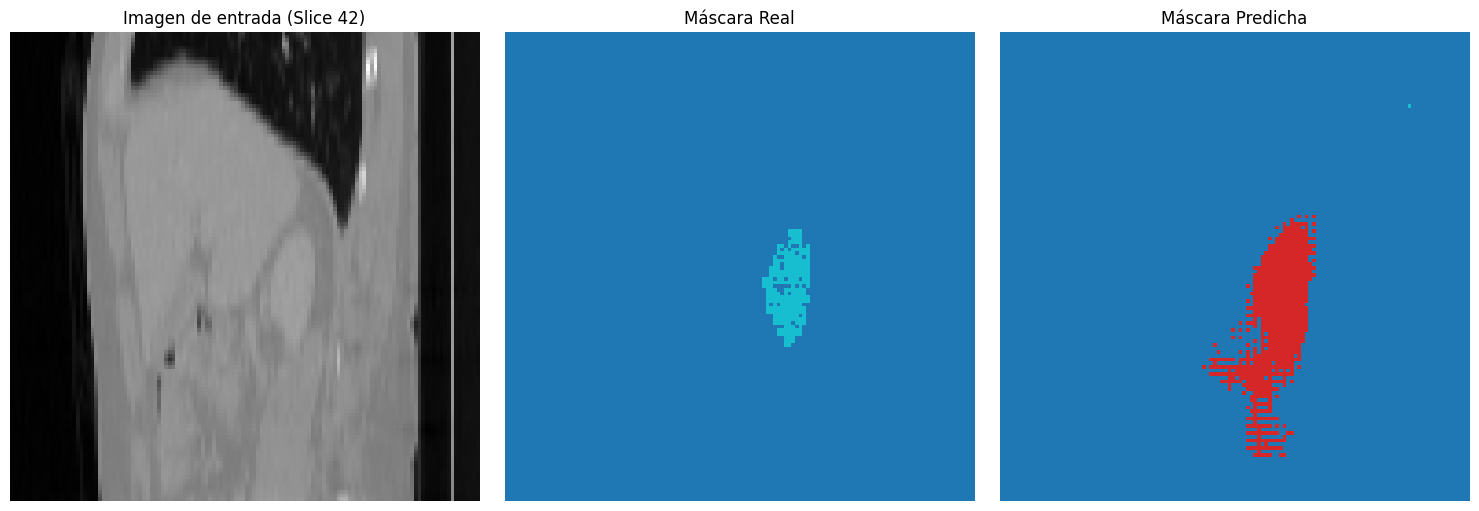

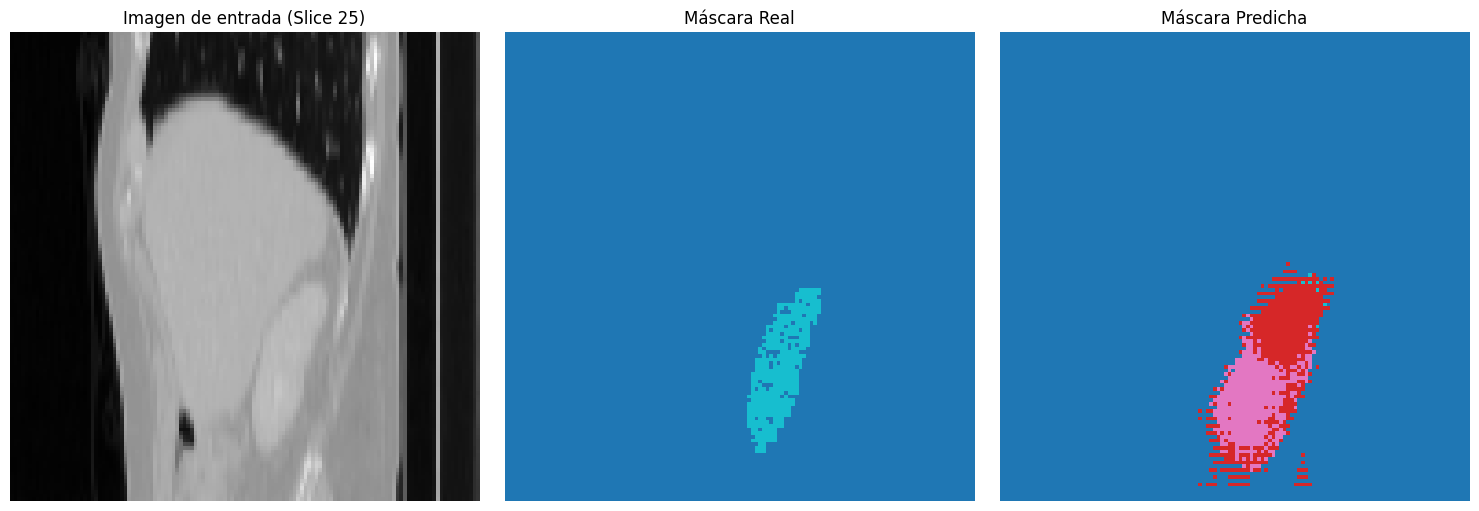

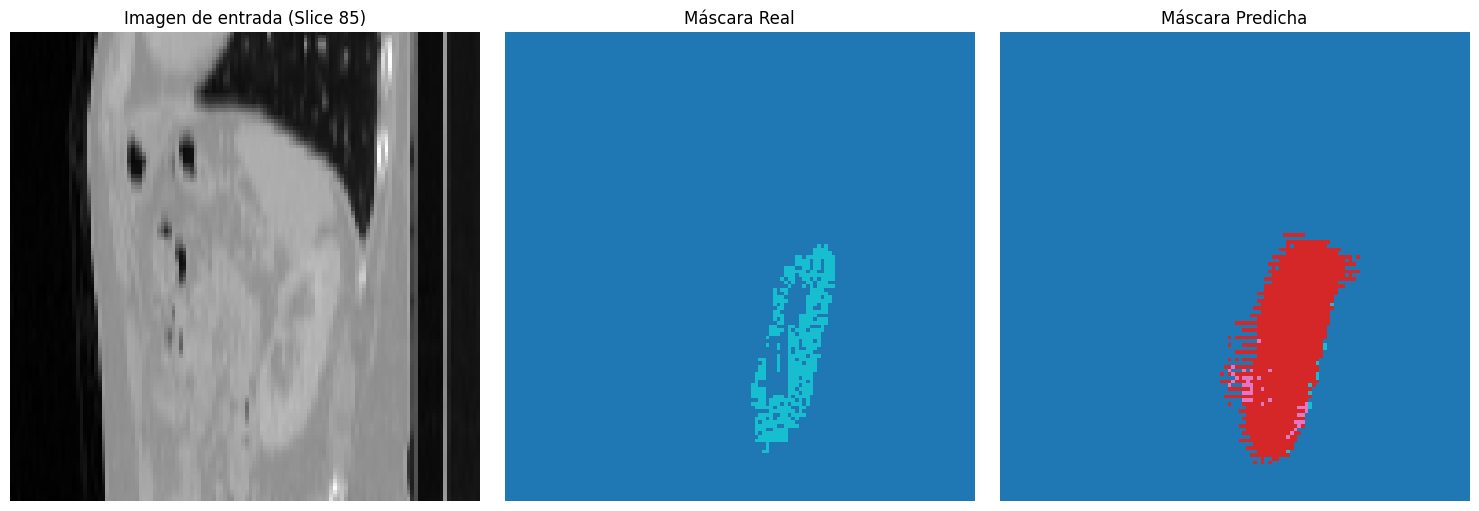

In [233]:
visualize_multiple_slices(model, test_dataset, index=0)

In [234]:
# Guardar modelo
torch.save(fine_tuned_model.state_dict(), "fine_tuned_segresnet.pth")

# Cargar modelo para continuar entrenando o hacer inferencias
fine_tuned_model.load_state_dict(torch.load("fine_tuned_segresnet.pth"))
fine_tuned_model.eval()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit2): Convolution(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(32, eps=1e-05, momentum=0.1, aff

# 2D Slices

In [223]:
%pip install segmentation-models-pytorch

Note: you may need to restart the kernel to use updated packages.


Importamos las librerías necesarias

In [224]:
#Importaciones
import os
import re
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.transforms import functional as TF
import segmentation_models_pytorch as smp
from tqdm import tqdm
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as widgets
from ipywidgets import interact

In [225]:
%pip install nibabel

Note: you may need to restart the kernel to use updated packages.


In [226]:
# Configuración del dispositivo
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [227]:
#Importar ruta del servidor
import os

# Definir el path de las imágenes del dataset 2D slices
slices2d_path = '/mnt/homeGPU/mcribilles/proy_final/2d_slices'


# Comprobar que existe la ruta o crearla
os.makedirs(slices2d_path, exist_ok=True)

# Mostrar cantidad de elementos en la carpeta
num_elements = len(os.listdir(slices2d_path))
print(f"Cantidad de elementos en la carpeta '{slices2d_path}': {num_elements}")

Cantidad de elementos en la carpeta '/mnt/homeGPU/mcribilles/proy_final/2d_slices': 124928


Vemos unos ejemplos de nuestros datos para entender el dataset. 

In [228]:
# Definimos el path de las imágenes del dataset
#dataset_path = 'data/kits23/dataset/'
dataset_path='/mnt/homeGPU/mcribilles/proy_final/data/kits23/dataset'

preprocessed_path = 'data/kits23/preprocessed_2/'
os.makedirs(preprocessed_path, exist_ok=True)

In [229]:
image_path = os.path.join(dataset_path, 'case_00000/imaging.nii.gz')
mask_path = os.path.join(dataset_path, 'case_00000/segmentation.nii.gz')

nii_image = nib.load(image_path)
image_data = nii_image.get_fdata()

nii_mask = nib.load(mask_path)
mask_data = nii_mask.get_fdata()

In [230]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import ipywidgets as widgets
from ipywidgets import interact
from scipy.ndimage import zoom

# Define the resize function for preprocessing
def resize_image(image, target_shape):
    factors = [t / s for t, s in zip(target_shape, image.shape)]
    return zoom(image, factors, order=0)  # order=1 applies linear interpolation

# Define the function to load images
def load_images(file_path):
    nii_image = nib.load(file_path)
    return nii_image.get_fdata()

# Define the preprocessing function
def preprocess_image_and_mask(image, mask, target_shape=(128, 128, 128)):
    # Resize images and masks
    image_resized = resize_image(image, target_shape)
    mask_resized = resize_image(mask, target_shape)
    
    # Normalize the image (Z-Score normalization)
    mean_value = np.mean(image_resized)
    std_value = np.std(image_resized)
    image_normalized = (image_resized - mean_value) / std_value
    
    # Ensure the mask is integer type
    mask_resized = mask_resized.astype(np.int32)
    
    return image_normalized, mask_resized


original_image = image_data
original_mask = mask_data

# Preprocess the images and masks
target_shape = (128, 128, 128)
preprocessed_image, preprocessed_mask = preprocess_image_and_mask(original_image, original_mask, target_shape)

# Define the colormap for masks
cmap = ListedColormap(['black', 'red', 'blue', 'green'])

# Proportional mapping between original and preprocessed slices
original_num_slices = original_image.shape[0]
preprocessed_num_slices = target_shape[0]

def get_original_slice(preprocessed_index):
    return int(preprocessed_index * original_num_slices / preprocessed_num_slices)

# Interactive function to plot a section
def plot_section(preprocessed_index):
    # Map the preprocessed index to the corresponding original index
    original_index = get_original_slice(preprocessed_index)
    
    # Original sections
    orig_image_section = original_image[original_index, :, :]
    orig_mask_section = original_mask[original_index, :, :]
    
    # Preprocessed sections
    pre_image_section = preprocessed_image[preprocessed_index, :, :]
    pre_mask_section = preprocessed_mask[preprocessed_index, :, :]

    fig, ax = plt.subplots(2, 2, figsize=(12, 12))

    # Plot original image
    ax[0, 0].imshow(orig_image_section, cmap='gray')
    ax[0, 0].set_title(f'Original Image Section {original_index}')
    ax[0, 0].axis('off')

    # Plot original mask
    ax[0, 1].imshow(orig_mask_section, cmap=cmap, interpolation='none')
    ax[0, 1].set_title(f'Original Mask Section {original_index}')
    ax[0, 1].axis('off')

    # Plot preprocessed image
    ax[1, 0].imshow(pre_image_section, cmap='gray')
    ax[1, 0].set_title(f'Preprocessed Image Section {preprocessed_index}')
    ax[1, 0].axis('off')

    # Plot preprocessed mask
    ax[1, 1].imshow(pre_mask_section, cmap=cmap, interpolation='none')
    ax[1, 1].set_title(f'Preprocessed Mask Section {preprocessed_index}')
    ax[1, 1].axis('off')

    # Add legend for masks
    legend_labels = ['0: Background', '1: Class 1', '2: Class 2', '3: Class 3']
    colors = [cmap(i) for i in range(4)]
    patches = [plt.matplotlib.patches.Patch(color=colors[i], label=legend_labels[i]) for i in range(4)]
    fig.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 0.5))

    plt.tight_layout()
    plt.show()

# Create the slider and display the interactive plot
interact(plot_section, preprocessed_index=widgets.IntSlider(min=0, max=preprocessed_num_slices-1, step=1, value=0));


interactive(children=(IntSlider(value=0, description='preprocessed_index', max=127), Output()), _dom_classes=(…

Vemos que la casilla anterior da un error, para ver las imágenes se debn importar e instalar las librerías anteriormente indicadas.

In [76]:
# RANGOS DE CASOS
valid_cases = [i for i in range(0, 588) if not (300 <= i <= 399)]  # Índices de los casos que existen, excluir casos 300-399
train_cases_full = valid_cases[:406]
test_cases = valid_cases[406:] # Casos test
train_cases = train_cases_full[:337] # Casos train
val_cases = train_cases_full[337:] # Casos val

In [77]:
# Obtenemos las rutas de archivos de imágenes y máscaras 
def get_image_and_mask_paths(path, range_filter):
    all_files = os.listdir(path)

    image_pattern = re.compile(r"^case_(\d{5})_.*_image.npy$")
    mask_pattern = re.compile(r"^case_(\d{5})_.*_mask.npy$")

    images = [f for f in all_files if image_pattern.match(f)]
    masks = [f for f in all_files if mask_pattern.match(f)]

    images = sorted(
        [f for f in images if range_filter(int(image_pattern.match(f).group(1)))]
    )
    masks = sorted(
        [f for f in masks if range_filter(int(mask_pattern.match(f).group(1)))]
    )

    return [(os.path.join(path, img), os.path.join(path, msk)) for img, msk in zip(images, masks)]



def load_image(path):
    img = np.load(path).astype(np.float32)
    img = np.squeeze(img)  # Remove extra dimensions
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim



def load_mask(path, n_classes=4):
    mask = np.load(path).astype(np.uint8)
    mask = np.squeeze(mask)
    return torch.tensor(mask, dtype=torch.long)



class KidneyDataset(Dataset):
    def __init__(self, pairs, n_classes=4):
        self.pairs = pairs
        self.n_classes = n_classes

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        image = load_image(img_path)
        mask = load_mask(mask_path, self.n_classes)
        return image, mask

# Get train and test pairs
train_pairs = get_image_and_mask_paths(slices2d_path, lambda x: 0 <= x <= 436)
val_pairs = get_image_and_mask_paths(slices2d_path, lambda x: 437 <= x <= 506)
test_pairs = get_image_and_mask_paths(slices2d_path, lambda x: 507 <= x <= 588)

print("Train pairs:", train_pairs[:5])
print("Validation pairs:", val_pairs[:5])
print("Test pairs:", test_pairs[:5])

Train pairs: [('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_000_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_000_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_001_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_001_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_002_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_002_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_003_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_003_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_004_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_004_mask.npy')]
Validation pairs: [('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00437_slice_000_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00437_slice_000_mask.npy'), ('/mnt/homeGP

In [78]:
# Crear Datasets
train_dataset = KidneyDataset(train_pairs)
val_dataset = KidneyDataset(val_pairs)
test_dataset = KidneyDataset(test_pairs)

# Crear DataLoaders
batch_size = 64 #al ser las imagenes 2d nos deja elevar el bs
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [79]:
# Metrics
def dice_score(pred, target, num_classes):
    pred = torch.argmax(pred, dim=1)
    scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        dice = (2 * intersection) / (union + 1e-6)
        scores.append(dice)
    return sum(scores) / len(scores)

In [80]:
from monai.networks.nets import UNet
import torch.nn as nn
from torch.nn.functional import softmax

def compute_metrics(predictions, targets, num_classes=4):
    # Convertir logits a clases
    pred_classes = torch.argmax(predictions, dim=1)

    iou = []
    dice = []

    for cls in range(num_classes):
        pred_mask = (pred_classes == cls).float()
        target_mask = (targets == cls).float()

        intersection = (pred_mask * target_mask).sum()
        union = pred_mask.sum() + target_mask.sum()

        iou_cls = intersection / (union - intersection + 1e-6)
        dice_cls = (2 * intersection) / (union + 1e-6)

        iou.append(iou_cls.item())
        dice.append(dice_cls.item())

    return {"IoU": iou, "Dice": dice}

# Definir funciones de pérdida (Dice + CrossEntropy)
def dice_loss(predictions, targets, num_classes=4):
    smooth = 1e-6
    dice = 0
    for cls in range(num_classes):
        pred = (torch.argmax(predictions, dim=1) == cls).float()
        target = (targets == cls).float()
        intersection = (pred * target).sum()
        dice += (2 * intersection + smooth) / (pred.sum() + target.sum() + smooth)
    return 1 - dice / num_classes

def combined_loss(predictions, targets):
    ce_loss = nn.CrossEntropyLoss()(predictions, targets.long())
    d_loss = dice_loss(predictions, targets)
    return 0.5 * ce_loss + 0.5 * d_loss


def focal_loss(logits, targets, alpha=0.25, gamma=2):
    probas = softmax(logits, dim=1)  # Convertir logits a probabilidades
    targets_one_hot = torch.nn.functional.one_hot(targets, num_classes=logits.size(1)).permute(0, 3, 1, 2).float()


    # Calcular el término focal y la pérdida
    focal_term = (1 - probas) ** gamma
    loss = -alpha * focal_term * targets_one_hot * torch.log(probas + 1e-6)

    return loss.mean()

In [81]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

n_classes = 4 #numero de clases
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#U-Net con un codificador resnet50 preentrenado en ImageNet
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1, #escala de grises
    classes=n_classes
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255) #Pérdida de entropía cruzada, ignorando el índice 255 (usualmente se usa para píxeles sin etiqueta)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training 
epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0.0 #inicializamos las metricas
    train_dice = 0.0

    # Training
    for images, masks in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{epochs}", position=0, leave=False):
        images, masks = images.to(device), masks.to(device) #cargamos los datos
        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs, masks)
        loss = focal_loss(outputs, masks, alpha=0.25, gamma=2)
        loss.backward() #Calcula los gradientes
        optimizer.step() #actualizamos los pesos

        train_loss += loss.item() #acumulamos la perdida
        train_dice += dice_score(outputs, masks, n_classes).item() #acumulamos dice score

        

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    all_metrics = {"IoU": [], "Dice": []}
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{epochs}", position=0, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            #loss = criterion(outputs, masks)
            loss = focal_loss(outputs, masks, alpha=0.25, gamma=2)


            val_loss += loss.item()
            val_dice += dice_score(outputs, masks, n_classes).item()

            # Calcular métricas
            metrics = compute_metrics(outputs, masks.squeeze(1).long(), num_classes=4)
            all_metrics["IoU"].append(metrics["IoU"])
            all_metrics["Dice"].append(metrics["Dice"])

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    # Promediar las métricas al final de la validación
    iou_mean = np.mean(all_metrics["IoU"], axis=0)
    dice_mean = np.mean(all_metrics["Dice"], axis=0)
    print(f"Val IoU: {iou_mean}, Val Dice: {dice_mean}")

    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Training Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")




# Evaluation loop
model.eval()
test_dice = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing", position=0, leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_dice += dice_score(outputs, masks, n_classes).item()

test_dice /= len(test_loader)
print(f"Test Dice Score: {test_dice:.4f}")

Val IoU: [0.99420032 0.29457132 0.         0.        ], Val Dice: [0.99708278 0.41416526 0.         0.        ]
Epoch 1/15, Train Loss: 0.0062, Training Dice: 0.2766
Validation Loss: 0.0011, Validation Dice: 0.3528


Val IoU: [0.99551971 0.39513198 0.         0.        ], Val Dice: [0.99774745 0.51932064 0.         0.        ]
Epoch 2/15, Train Loss: 0.0007, Training Dice: 0.3673
Validation Loss: 0.0005, Validation Dice: 0.3793


Val IoU: [0.99621809 0.42047645 0.05612253 0.        ], Val Dice: [0.99810143 0.54720174 0.0835557  0.        ]
Epoch 3/15, Train Loss: 0.0004, Training Dice: 0.4026
Validation Loss: 0.0004, Validation Dice: 0.4072


Val IoU: [0.99668494 0.47438038 0.08324891 0.        ], Val Dice: [0.99833667 0.5936557  0.12073296 0.        ]
Epoch 4/15, Train Loss: 0.0003, Training Dice: 0.4226
Validation Loss: 0.0004, Validation Dice: 0.4282


Val IoU: [0.99652241 0.45833023 0.08608042 0.        ], Val Dice: [0.99825474 0.58054746 0.1243483  0.        ]
Epoch 5/15, Train Loss: 0.0002, Training Dice: 0.4355
Validation Loss: 0.0004, Validation Dice: 0.4258


Val IoU: [0.99661421 0.48010235 0.09520434 0.        ], Val Dice: [0.99830093 0.60005732 0.13787134 0.        ]
Epoch 6/15, Train Loss: 0.0002, Training Dice: 0.4393
Validation Loss: 0.0004, Validation Dice: 0.4341


Val IoU: [0.99691124 0.49530674 0.10346157 0.        ], Val Dice: [0.99844929 0.61098607 0.14975119 0.        ]
Epoch 7/15, Train Loss: 0.0002, Training Dice: 0.4507
Validation Loss: 0.0003, Validation Dice: 0.4398


Val IoU: [0.99685956 0.49286781 0.09036328 0.        ], Val Dice: [0.99842349 0.60793203 0.13073587 0.        ]
Epoch 8/15, Train Loss: 0.0002, Training Dice: 0.4598
Validation Loss: 0.0003, Validation Dice: 0.4343


Val IoU: [0.99667151 0.46805135 0.09076132 0.        ], Val Dice: [0.99832839 0.58471504 0.13003951 0.        ]
Epoch 9/15, Train Loss: 0.0002, Training Dice: 0.4631
Validation Loss: 0.0004, Validation Dice: 0.4283


Val IoU: [0.99618872 0.46359742 0.08146157 0.        ], Val Dice: [0.99808504 0.57657637 0.11842283 0.        ]
Epoch 10/15, Train Loss: 0.0002, Training Dice: 0.4447
Validation Loss: 0.0004, Validation Dice: 0.4233


Val IoU: [0.99554118 0.43363729 0.10055734 0.        ], Val Dice: [0.99775981 0.55132612 0.14664345 0.        ]
Epoch 11/15, Train Loss: 0.0002, Training Dice: 0.4574
Validation Loss: 0.0005, Validation Dice: 0.4239


Val IoU: [0.99701386 0.50780423 0.13262814 0.        ], Val Dice: [0.99850089 0.62200896 0.19063382 0.        ]
Epoch 12/15, Train Loss: 0.0002, Training Dice: 0.4689
Validation Loss: 0.0003, Validation Dice: 0.4528


Val IoU: [0.99702844 0.50467013 0.13686176 0.00159824], Val Dice: [0.99850813 0.61947434 0.19655796 0.00300775]
Epoch 13/15, Train Loss: 0.0001, Training Dice: 0.4815
Validation Loss: 0.0004, Validation Dice: 0.4544


Val IoU: [0.99666767 0.48741778 0.13515107 0.00285619], Val Dice: [0.99832737 0.60168745 0.19732628 0.00499073]
Epoch 14/15, Train Loss: 0.0001, Training Dice: 0.4943
Validation Loss: 0.0004, Validation Dice: 0.4506


Val IoU: [0.99691453 0.50464233 0.13366429 0.00994679], Val Dice: [0.99845114 0.6182561  0.19302059 0.01564303]
Epoch 15/15, Train Loss: 0.0002, Training Dice: 0.4771
Validation Loss: 0.0004, Validation Dice: 0.4563


Test Dice Score: 0.4245



El modelo 2D logra segmentar bien el riñón (Dice: 0.9984), pero tiene un desempeño limitado en tumores y quistes (Dice: 0.6183 y 0.1930), debido al desbalance de clases y la pérdida de información espacial. El resultado global en prueba (Dice: 0.4245) confirma estas limitaciones. Para mejorar los resultados, probaremos oversampling y subsampling.

In [82]:
import os
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import jaccard_score  # For IoU/Jaccard

# Directory to save predicted masks
output_dir = "./predictions"
os.makedirs(output_dir, exist_ok=True)

# Function to calculate per-class Dice coefficient
def per_class_dice_score(outputs, targets, n_classes):
    dices = []
    outputs = F.softmax(outputs, dim=1).argmax(dim=1)  # Convert logits to class predictions
    for c in range(n_classes):
        pred_c = (outputs == c).float()
        target_c = (targets == c).float()
        intersection = (pred_c * target_c).sum(dim=[1, 2])  # Sum over spatial dimensions
        union = pred_c.sum(dim=[1, 2]) + target_c.sum(dim=[1, 2])  # Sum of individual masks
        dice = (2 * intersection / (union + 1e-6)).mean().item()  # Avoid divide by zero
        dices.append(dice)
    return dices

# Initialize metrics
per_class_dices = np.zeros(n_classes)
total_jaccard = np.zeros(n_classes)
test_dice = 0.0
num_samples = len(test_loader)

# Store predictions and metrics
model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing", position=0, leave=False)):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # Save predicted masks
        preds = F.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy()  # Convert to class predictions
        for i, pred in enumerate(preds):
            np.save(os.path.join(output_dir, f"prediction_{idx * test_loader.batch_size + i}.npy"), pred)
        
        # Calculate metrics
        test_dice += dice_score(outputs, masks, n_classes).item()
        per_class_dices += np.array(per_class_dice_score(outputs, masks, n_classes))
        
        # Compute per-class IoU (Jaccard index)
        preds_flat = preds.flatten()
        masks_flat = masks.cpu().numpy().flatten()
        for c in range(n_classes):
            jaccard = jaccard_score(
                (masks_flat == c).astype(int),
                (preds_flat == c).astype(int),
                average="binary",
                zero_division=0
            )
            total_jaccard[c] += jaccard

# Average metrics
test_dice /= num_samples
per_class_dices /= num_samples
total_jaccard /= num_samples

# Print results
print(f"Test Dice Score (Overall): {test_dice:.4f}")
for c in range(n_classes):
    print(f"Class {c}: Dice = {per_class_dices[c]:.4f}, IoU = {total_jaccard[c]:.4f}")


Testing:   0%|          | 0/162 [00:00<?, ?it/s]

Test Dice Score (Overall): 0.4245
Class 0: Dice = 0.9975, IoU = 0.9951
Class 1: Dice = 0.2324, IoU = 0.4079
Class 2: Dice = 0.0592, IoU = 0.1171
Class 3: Dice = 0.0010, IoU = 0.0048


El modelo muestra un claro sesgo hacia las clases dominantes, con un desempeño muy pobre en las minoritarias (clases 1-3). Esto evidencia la necesidad de abordar el desbalance de clases mediante estrategias como CB Loss, focal loss, o aumentos específicos para clases minoritarias, además de considerar arquitecturas 3D que capturen mejor la información volumétrica del dataset.

## Ahora vamos a probar a hacer oversampling
Tenemos un desbalanceo enorme que no deja que aprenda lo importante, ya que casi todo es fondo (la clase 0) y esa sí la predice muy bien porque hay muchos ejemplos, pero no es la que nos interesa. 
Vamos a probar a hacer oversampling, es decir, de las clases minoritarias vamos a aumentar los datos. 

In [83]:
# Calcular pesos para realizar sobremuestreo
class_counts = torch.zeros(4)  # Tenemos 4 clases
for _, mask_path in tqdm(train_pairs):
    mask = load_mask(mask_path).numpy()
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        class_counts[cls] += count

class_weights = 1.0 / (class_counts + 1e-6)  # Se suma 1e-6 para evitar división por cero

sample_weights = []
for _, mask_path in tqdm(train_pairs):
    mask = load_mask(mask_path).numpy()
    unique, counts = np.unique(mask, return_counts=True)
    weight = sum(class_weights[cls] * count for cls, count in zip(unique, counts))
    sample_weights.append(weight.item())

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

100%|██████████| 43136/43136 [00:28<00:00, 1515.04it/s]


In [84]:
# Crear Datasets
train_dataset = KidneyDataset(train_pairs)
val_dataset = KidneyDataset(val_pairs)
test_dataset = KidneyDataset(test_pairs)

# Crear DataLoaders (añadimos el sampler)
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [85]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

n_classes = 4 #numero de clases
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#U-Net con un codificador resnet50 preentrenado en ImageNet
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1, #escala de grises
    classes=n_classes
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255) #Pérdida de entropía cruzada, ignorando el índice 255 (usualmente se usa para píxeles sin etiqueta)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training 
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0.0 #inicializamos las metricas
    train_dice = 0.0

    # Training
    for images, masks in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{epochs}", position=0, leave=False):
        images, masks = images.to(device), masks.to(device) #cargamos los datos
        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs, masks)
        loss = focal_loss(outputs, masks, alpha=0.25, gamma=2)
        loss.backward() #Calcula los gradientes
        optimizer.step() #actualizamos los pesos

        train_loss += loss.item() #acumulamos la perdida
        train_dice += dice_score(outputs, masks, n_classes).item() #acumulamos dice score

        

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    all_metrics = {"IoU": [], "Dice": []}
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{epochs}", position=0, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            #loss = criterion(outputs, masks)
            loss = focal_loss(outputs, masks, alpha=0.25, gamma=2)


            val_loss += loss.item()
            val_dice += dice_score(outputs, masks, n_classes).item()

            # Calcular métricas
            metrics = compute_metrics(outputs, masks.squeeze(1).long(), num_classes=4)
            all_metrics["IoU"].append(metrics["IoU"])
            all_metrics["Dice"].append(metrics["Dice"])

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    # Promediar las métricas al final de la validación
    iou_mean = np.mean(all_metrics["IoU"], axis=0)
    dice_mean = np.mean(all_metrics["Dice"], axis=0)
    print(f"Val IoU: {iou_mean}, Val Dice: {dice_mean}")

    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Training Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")




# Evaluation loop
model.eval()
test_dice = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing", position=0, leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_dice += dice_score(outputs, masks, n_classes).item()

test_dice /= len(test_loader)
print(f"Test Dice Score: {test_dice:.4f}")

Val IoU: [9.96581551e-01 4.80995085e-01 4.99489284e-02 1.53147635e-04], Val Dice: [9.98284318e-01 6.02415725e-01 7.45415102e-02 3.03157276e-04]
Epoch 1/10, Train Loss: 0.0047, Training Dice: 0.6137
Validation Loss: 0.0006, Validation Dice: 0.4189


Val IoU: [9.96911054e-01 5.05185974e-01 6.32590749e-02 5.28641110e-04], Val Dice: [0.99845025 0.62358416 0.09447167 0.00101215]
Epoch 2/10, Train Loss: 0.0007, Training Dice: 0.8254
Validation Loss: 0.0004, Validation Dice: 0.4294


Val IoU: [9.96992455e-01 5.06758456e-01 6.25636341e-02 1.70372362e-04], Val Dice: [9.98491112e-01 6.23598369e-01 9.38604760e-02 3.33217119e-04]
Epoch 3/10, Train Loss: 0.0005, Training Dice: 0.8507
Validation Loss: 0.0004, Validation Dice: 0.4291


Val IoU: [9.96911668e-01 4.97067158e-01 6.34739027e-02 2.08246572e-05], Val Dice: [9.98450394e-01 6.15633053e-01 9.41204805e-02 4.15282390e-05]
Epoch 4/10, Train Loss: 0.0004, Training Dice: 0.8626
Validation Loss: 0.0004, Validation Dice: 0.4271


Val IoU: [9.97108444e-01 5.14408019e-01 6.92433867e-02 4.55163790e-04], Val Dice: [9.98549384e-01 6.30565258e-01 1.02327886e-01 8.77945976e-04]
Epoch 5/10, Train Loss: 0.0004, Training Dice: 0.8675
Validation Loss: 0.0004, Validation Dice: 0.4331


Val IoU: [9.97134856e-01 5.14239595e-01 8.06291159e-02 1.77280272e-04], Val Dice: [9.98562787e-01 6.29727542e-01 1.18036896e-01 3.51701160e-04]
Epoch 6/10, Train Loss: 0.0004, Training Dice: 0.8747
Validation Loss: 0.0004, Validation Dice: 0.4367


Val IoU: [9.97075213e-01 5.20232029e-01 7.04236690e-02 5.87301845e-04], Val Dice: [0.99853233 0.63490895 0.10274754 0.00110627]
Epoch 7/10, Train Loss: 0.0003, Training Dice: 0.8794
Validation Loss: 0.0004, Validation Dice: 0.4343


Val IoU: [9.97293368e-01 5.26539287e-01 8.21974594e-02 3.15231555e-04], Val Dice: [9.98642574e-01 6.40899097e-01 1.20456219e-01 6.08740379e-04]
Epoch 8/10, Train Loss: 0.0003, Training Dice: 0.8830
Validation Loss: 0.0004, Validation Dice: 0.4402


Val IoU: [9.97248487e-01 5.24666952e-01 8.24071142e-02 4.22905761e-04], Val Dice: [9.98619874e-01 6.38968608e-01 1.20768294e-01 8.02177215e-04]
Epoch 9/10, Train Loss: 0.0003, Training Dice: 0.8874
Validation Loss: 0.0004, Validation Dice: 0.4398


Val IoU: [9.97284378e-01 5.29104732e-01 8.50750383e-02 4.07016500e-04], Val Dice: [9.98637956e-01 6.42553798e-01 1.24696924e-01 7.97921872e-04]
Epoch 10/10, Train Loss: 0.0003, Training Dice: 0.8907
Validation Loss: 0.0004, Validation Dice: 0.4417


Test Dice Score: 0.4272


In [86]:
import os
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import jaccard_score  # For IoU/Jaccard

# Directory to save predicted masks
output_dir = "./predictions"
os.makedirs(output_dir, exist_ok=True)

# Function to calculate per-class Dice coefficient
def per_class_dice_score(outputs, targets, n_classes):
    dices = []
    outputs = F.softmax(outputs, dim=1).argmax(dim=1)  # Convert logits to class predictions
    for c in range(n_classes):
        pred_c = (outputs == c).float()
        target_c = (targets == c).float()
        intersection = (pred_c * target_c).sum(dim=[1, 2])  # Sum over spatial dimensions
        union = pred_c.sum(dim=[1, 2]) + target_c.sum(dim=[1, 2])  # Sum of individual masks
        dice = (2 * intersection / (union + 1e-6)).mean().item()  # Avoid divide by zero
        dices.append(dice)
    return dices

# Initialize metrics
per_class_dices = np.zeros(n_classes)
total_jaccard = np.zeros(n_classes)
test_dice = 0.0
num_samples = len(test_loader)

# Store predictions and metrics
model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing", position=0, leave=False)):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # Save predicted masks
        preds = F.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy()  # Convert to class predictions
        for i, pred in enumerate(preds):
            np.save(os.path.join(output_dir, f"prediction_{idx * test_loader.batch_size + i}.npy"), pred)
        
        # Calculate metrics
        test_dice += dice_score(outputs, masks, n_classes).item()
        per_class_dices += np.array(per_class_dice_score(outputs, masks, n_classes))
        
        # Compute per-class IoU (Jaccard index)
        preds_flat = preds.flatten()
        masks_flat = masks.cpu().numpy().flatten()
        for c in range(n_classes):
            jaccard = jaccard_score(
                (masks_flat == c).astype(int),
                (preds_flat == c).astype(int),
                average="binary",
                zero_division=0
            )
            total_jaccard[c] += jaccard

# Average metrics
test_dice /= num_samples
per_class_dices /= num_samples
total_jaccard /= num_samples

# Print results
print(f"Test Dice Score (Overall): {test_dice:.4f}")
for c in range(n_classes):
    print(f"Class {c}: Dice = {per_class_dices[c]:.4f}, IoU = {total_jaccard[c]:.4f}")


Test Dice Score (Overall): 0.4272
Class 0: Dice = 0.9975, IoU = 0.9951
Class 1: Dice = 0.2432, IoU = 0.4473
Class 2: Dice = 0.0452, IoU = 0.1042
Class 3: Dice = 0.0000, IoU = 0.0001


Aunque el oversampling mejora marginalmente la segmentación de tumores, no es suficiente para abordar el desbalance de clases, especialmente en quistes. Probaremos a hacer subsampling.

## Subsampling
No es tan recomendado ya que sería eliminar datos que tenemos disponibles, sabiendo eso vamos a hacer una pequeña prueba para comparar resultados. 
Le ponemos un umbral muy alto ya que probando con un umbral de 0.95 se quedaba casi sin datos por lo desbalanceado que está el dataset. 

In [87]:
def filter_undersample(pairs, class_to_filter=0, threshold=0.99, n_classes=4):
    """
    Filters out pairs where the proportion of `class_to_filter` in the mask exceeds `threshold`.
    """
    filtered_pairs = []
    for img_path, mask_path in tqdm(pairs, desc="Filtering pairs"):
        mask = load_mask(mask_path, n_classes).numpy()
        total_pixels = mask.size
        class_0_count = (mask == class_to_filter).sum()
        if class_0_count / total_pixels <= threshold:  # Keep only if below threshold
            filtered_pairs.append((img_path, mask_path))
    return filtered_pairs

In [88]:
# Define dataset path
slices2d_path = '/mnt/homeGPU/mcribilles/proy_final/2d_slices'
os.makedirs(slices2d_path, exist_ok=True)

# Display the number of elements in the folder
num_elements = len(os.listdir(slices2d_path))
print(f"Cantidad de elementos en la carpeta '{slices2d_path}': {num_elements}")


# Helper functions to fetch pairs of images and masks
def get_image_and_mask_paths(path, range_filter):
    all_files = os.listdir(path)

    image_pattern = re.compile(r"^case_(\d{5})_.*_image.npy$")
    mask_pattern = re.compile(r"^case_(\d{5})_.*_mask.npy$")

    images = [f for f in all_files if image_pattern.match(f)]
    masks = [f for f in all_files if mask_pattern.match(f)]

    images = sorted(
        [f for f in images if range_filter(int(image_pattern.match(f).group(1)))]
    )
    masks = sorted(
        [f for f in masks if range_filter(int(mask_pattern.match(f).group(1)))]
    )

    return [(os.path.join(path, img), os.path.join(path, msk)) for img, msk in zip(images, masks)]

def load_image(path):
    img = np.load(path).astype(np.float32)
    img = np.squeeze(img)  # Remove extra dimensions
    return torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add channel dim

def load_mask(path, n_classes=4):
    mask = np.load(path).astype(np.uint8)
    mask = np.squeeze(mask)
    return torch.tensor(mask, dtype=torch.long)

class KidneyDataset(Dataset):
    def __init__(self, pairs, n_classes=4):
        self.pairs = pairs
        self.n_classes = n_classes

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        image = load_image(img_path)
        mask = load_mask(mask_path, self.n_classes)
        return image, mask

# Get train and test pairs
train_pairs = get_image_and_mask_paths(slices2d_path, lambda x: 0 <= x <= 436)
val_pairs = get_image_and_mask_paths(slices2d_path, lambda x: 437 <= x <= 506)
test_pairs = get_image_and_mask_paths(slices2d_path, lambda x: 507 <= x <= 588)

print("Train pairs:", train_pairs[:5])
print("Validation pairs:", val_pairs[:5])
print("Test pairs:", test_pairs[:5])

train_pairs = filter_undersample(train_pairs, class_to_filter=0, threshold=0.99)

# Calculate weights for oversampling
class_counts = torch.zeros(4)  # Assuming 4 classes
for _, mask_path in tqdm(train_pairs):
    mask = load_mask(mask_path).numpy()
    unique, counts = np.unique(mask, return_counts=True)
    for cls, count in zip(unique, counts):
        class_counts[cls] += count

class_weights = 1e+6 / (class_counts ** 3 + 1e-6)  # Avoid division by zero

sample_weights = []
for _, mask_path in tqdm(train_pairs):
    mask = load_mask(mask_path).numpy()
    unique, counts = np.unique(mask, return_counts=True)
    weight = sum(class_weights[cls] * count for cls, count in zip(unique, counts))
    sample_weights.append(weight.item())

sampler = WeightedRandomSampler(sample_weights, len(sample_weights))






Cantidad de elementos en la carpeta '/mnt/homeGPU/mcribilles/proy_final/2d_slices': 124928
Train pairs: [('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_000_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_000_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_001_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_001_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_002_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_002_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_003_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_003_mask.npy'), ('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_004_image.npy', '/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00000_slice_004_mask.npy')]
Validation pairs: [('/mnt/homeGPU/mcribilles/proy_final/2d_slices/case_00437_slice_000_image.npy', '

100%|██████████| 11679/11679 [00:09<00:00, 1297.04it/s]


In [89]:
# Create datasets and dataloaders
batch_size = 64
train_dataset = KidneyDataset(train_pairs)
val_dataset = KidneyDataset(val_pairs)
test_dataset = KidneyDataset(test_pairs)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


In [90]:
import segmentation_models_pytorch as smp
from tqdm import tqdm

n_classes = 4 #numero de clases
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#U-Net con un codificador resnet50 preentrenado en ImageNet
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=1, #escala de grises
    classes=n_classes
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255) #Pérdida de entropía cruzada, ignorando el índice 255 (usualmente se usa para píxeles sin etiqueta)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training 
epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0.0 #inicializamos las metricas
    train_dice = 0.0

    # Training
    for images, masks in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{epochs}", position=0, leave=False):
        images, masks = images.to(device), masks.to(device) #cargamos los datos
        optimizer.zero_grad()
        outputs = model(images)
        #loss = criterion(outputs, masks)
        loss = focal_loss(outputs, masks, alpha=0.25, gamma=2)
        loss.backward() #Calcula los gradientes
        optimizer.step() #actualizamos los pesos

        train_loss += loss.item() #acumulamos la perdida
        train_dice += dice_score(outputs, masks, n_classes).item() #acumulamos dice score

        

    train_loss /= len(train_loader)
    train_dice /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    all_metrics = {"IoU": [], "Dice": []}
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{epochs}", position=0, leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            #loss = criterion(outputs, masks)
            loss = focal_loss(outputs, masks, alpha=0.25, gamma=2)


            val_loss += loss.item()
            val_dice += dice_score(outputs, masks, n_classes).item()

            # Calcular métricas
            metrics = compute_metrics(outputs, masks.squeeze(1).long(), num_classes=4)
            all_metrics["IoU"].append(metrics["IoU"])
            all_metrics["Dice"].append(metrics["Dice"])

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)

    # Promediar las métricas al final de la validación
    iou_mean = np.mean(all_metrics["IoU"], axis=0)
    dice_mean = np.mean(all_metrics["Dice"], axis=0)
    print(f"Val IoU: {iou_mean}, Val Dice: {dice_mean}")

    
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Training Dice: {train_dice:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Dice: {val_dice:.4f}")




# Evaluation loop
model.eval()
test_dice = 0.0
with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing", position=0, leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        test_dice += dice_score(outputs, masks, n_classes).item()

test_dice /= len(test_loader)
print(f"Test Dice Score: {test_dice:.4f}")

Val IoU: [0.99487111 0.35759571 0.         0.        ], Val Dice: [0.99742103 0.48179957 0.         0.        ]
Epoch 1/15, Train Loss: 0.0147, Training Dice: 0.3897
Validation Loss: 0.0035, Validation Dice: 0.3698


Val IoU: [0.99488957 0.38152272 0.00126979 0.00332629], Val Dice: [0.997431   0.50767038 0.0024714  0.00590968]
Epoch 2/15, Train Loss: 0.0026, Training Dice: 0.5382
Validation Loss: 0.0013, Validation Dice: 0.3784


Val IoU: [0.99477563 0.37197946 0.01215012 0.00258299], Val Dice: [0.99737437 0.49704802 0.02236302 0.00468549]
Epoch 3/15, Train Loss: 0.0013, Training Dice: 0.7448
Validation Loss: 0.0009, Validation Dice: 0.3804


Val IoU: [0.99312547 0.35925388 0.02015324 0.00262216], Val Dice: [0.99654355 0.48342104 0.03490539 0.00453725]
Epoch 4/15, Train Loss: 0.0009, Training Dice: 0.7948
Validation Loss: 0.0008, Validation Dice: 0.3799


Val IoU: [0.99193983 0.35367473 0.02923582 0.00122573], Val Dice: [0.99594577 0.47699819 0.04874699 0.00222144]
Epoch 5/15, Train Loss: 0.0007, Training Dice: 0.8112
Validation Loss: 0.0008, Validation Dice: 0.3810


Val IoU: [0.99396383 0.36534751 0.02997489 0.00113025], Val Dice: [0.99696762 0.48943276 0.05027675 0.00203782]
Epoch 6/15, Train Loss: 0.0006, Training Dice: 0.8239
Validation Loss: 0.0007, Validation Dice: 0.3847


Val IoU: [9.93237991e-01 3.53918799e-01 2.64137301e-02 5.42681685e-04], Val Dice: [0.99660114 0.47713165 0.04433309 0.00101724]
Epoch 7/15, Train Loss: 0.0005, Training Dice: 0.8323
Validation Loss: 0.0007, Validation Dice: 0.3798


Val IoU: [0.99315199 0.3588688  0.03487282 0.0009978 ], Val Dice: [0.99655864 0.48164859 0.05797786 0.00184773]
Epoch 8/15, Train Loss: 0.0005, Training Dice: 0.8380
Validation Loss: 0.0007, Validation Dice: 0.3845


Val IoU: [9.92470564e-01 3.59327628e-01 3.23097450e-02 8.62172374e-04], Val Dice: [0.99621453 0.48236661 0.05390114 0.00155249]
Epoch 9/15, Train Loss: 0.0004, Training Dice: 0.8412
Validation Loss: 0.0008, Validation Dice: 0.3835


Val IoU: [0.99349158 0.37409328 0.04080687 0.00103986], Val Dice: [0.99673037 0.49856587 0.066979   0.00186259]
Epoch 10/15, Train Loss: 0.0004, Training Dice: 0.8509
Validation Loss: 0.0007, Validation Dice: 0.3910


Val IoU: [9.93451892e-01 3.73363648e-01 3.93989987e-02 9.76901289e-04], Val Dice: [0.99671068 0.49795454 0.06487985 0.00176248]
Epoch 11/15, Train Loss: 0.0004, Training Dice: 0.8568
Validation Loss: 0.0007, Validation Dice: 0.3903


Val IoU: [0.99386452 0.38011031 0.03337589 0.00106753], Val Dice: [0.99691814 0.5054397  0.05548922 0.00187672]
Epoch 12/15, Train Loss: 0.0004, Training Dice: 0.8601
Validation Loss: 0.0007, Validation Dice: 0.3899


Val IoU: [0.99305696 0.36769784 0.036755   0.00137204], Val Dice: [0.99651176 0.49276348 0.06059863 0.00239032]
Epoch 13/15, Train Loss: 0.0003, Training Dice: 0.8654
Validation Loss: 0.0007, Validation Dice: 0.3881


Val IoU: [0.99326906 0.38283564 0.04599385 0.0047551 ], Val Dice: [0.99661858 0.50764566 0.07436895 0.00821995]
Epoch 14/15, Train Loss: 0.0004, Training Dice: 0.8564
Validation Loss: 0.0007, Validation Dice: 0.3967


Val IoU: [0.99469525 0.39303509 0.04349549 0.00213232], Val Dice: [0.99733705 0.51770912 0.069582   0.00357765]
Epoch 15/15, Train Loss: 0.0004, Training Dice: 0.8507
Validation Loss: 0.0006, Validation Dice: 0.3971


Test Dice Score: 0.3817


In [91]:
import os
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import jaccard_score  # For IoU/Jaccard

# Directory to save predicted masks
output_dir = "./predictions"
os.makedirs(output_dir, exist_ok=True)

# Function to calculate per-class Dice coefficient
def per_class_dice_score(outputs, targets, n_classes):
    dices = []
    outputs = F.softmax(outputs, dim=1).argmax(dim=1)  # Convert logits to class predictions
    for c in range(n_classes):
        pred_c = (outputs == c).float()
        target_c = (targets == c).float()
        intersection = (pred_c * target_c).sum(dim=[1, 2])  # Sum over spatial dimensions
        union = pred_c.sum(dim=[1, 2]) + target_c.sum(dim=[1, 2])  # Sum of individual masks
        dice = (2 * intersection / (union + 1e-6)).mean().item()  # Avoid divide by zero
        dices.append(dice)
    return dices

# Initialize metrics
per_class_dices = np.zeros(n_classes)
total_jaccard = np.zeros(n_classes)
test_dice = 0.0
num_samples = len(test_loader)

# Store predictions and metrics
model.eval()
with torch.no_grad():
    for idx, (images, masks) in enumerate(tqdm(test_loader, desc="Testing", position=0, leave=False)):
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        
        # Save predicted masks
        preds = F.softmax(outputs, dim=1).argmax(dim=1).cpu().numpy()  # Convert to class predictions
        for i, pred in enumerate(preds):
            np.save(os.path.join(output_dir, f"prediction_{idx * test_loader.batch_size + i}.npy"), pred)
        
        # Calculate metrics
        test_dice += dice_score(outputs, masks, n_classes).item()
        per_class_dices += np.array(per_class_dice_score(outputs, masks, n_classes))
        
        # Compute per-class IoU (Jaccard index)
        preds_flat = preds.flatten()
        masks_flat = masks.cpu().numpy().flatten()
        for c in range(n_classes):
            jaccard = jaccard_score(
                (masks_flat == c).astype(int),
                (preds_flat == c).astype(int),
                average="binary",
                zero_division=0
            )
            total_jaccard[c] += jaccard

# Average metrics
test_dice /= num_samples
per_class_dices /= num_samples
total_jaccard /= num_samples

# Print results
print(f"Test Dice Score (Overall): {test_dice:.4f}")
for c in range(n_classes):
    print(f"Class {c}: Dice = {per_class_dices[c]:.4f}, IoU = {total_jaccard[c]:.4f}")


Test Dice Score (Overall): 0.3817
Class 0: Dice = 0.9961, IoU = 0.9924
Class 1: Dice = 0.2175, IoU = 0.3179
Class 2: Dice = 0.0351, IoU = 0.0590
Class 3: Dice = 0.0004, IoU = 0.0007


El subsampling parece perjudicar el rendimiento global (Test Dice: 0.3817), especialmente en las clases mayoritarias, mientras no logra mejorar significativamente las minoritarias. Esta técnica puede reducir el sesgo hacia clases dominantes, pero al hacerlo también elimina información valiosa.

## Conclusion

La comparación entre los resultados de oversampling, subsampling y modelos 2D pone en evidencia las limitaciones de estos enfoques para segmentar imágenes médicas desbalanceadas, especialmente en clases más complejas como tumores y quistes. Aunque el oversampling logró pequeñas mejoras, sobre todo en la segmentación de tumores, ninguno de los dos métodos logró solucionar de manera efectiva el problema del desbalance de clases. En general, el rendimiento global, con un Test Dice cercano a 0.42, sigue siendo insuficiente.

Por otro lado, los modelos 3D han mostrado una clara ventaja al aprovechar la información espacial completa de las imágenes volumétricas. Esto se traduce en resultados mucho más consistentes, incluso en las clases menos representadas. Estas observaciones destacan las limitaciones intrínsecas de los modelos 2D para abordar este tipo de tareas, aun cuando se implementen estrategias de balanceo de clases.